In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torch.autograd
from torch.autograd import Variable
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
from collections import deque
from tqdm import tqdm, trange
import random
import sys
import matplotlib.pyplot as plt
import scipy.io


In [2]:

class Critic_network(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(Critic_network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

class Actor_network(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(Actor_network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, state):
        x = self.fc1(state)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = torch.tanh(x)

        return x

In [3]:
class DDPGagent:
    def __init__(self, env, hidden_size_1=512, hidden_size_2=256, actor_lr=1e-4, critic_lr=1e-3, gamma=0.99, tau=1e-2, max_buffer_size=50000, batch_size = 128):
        self.states_number = env.observation_space.shape[0]
        self.actions_number = env.action_space.shape[0]
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.gamma = gamma
        self.tau = tau
        self.buffer = deque(maxlen = max_buffer_size)
        self.batch_size = batch_size
        self.actor = Actor_network(self.states_number, hidden_size_1, hidden_size_2, self.actions_number).cuda()
        self.actor_target = Actor_network(self.states_number, hidden_size_1, hidden_size_2, self.actions_number).cuda()
        self.critic = Critic_network(self.states_number + self.actions_number, hidden_size_1, hidden_size_2, self.actions_number).cuda()
        self.critic_target = Critic_network(self.states_number + self.actions_number, hidden_size_1, hidden_size_2, self.actions_number).cuda()

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
    
    def get_action(self, observation):
        observation = torch.tensor(observation).float()
        action = self.actor.forward(observation.cuda())
        action = action.cpu().detach().numpy()
        return action
    
    def noise(self, action, t):
        noise_sample = 2.5 * np.exp(- t / 1000) * np.random.randn(self.actions_number)
        action_noise =  np.clip(action + noise_sample, self.action_low, self.action_high)
        return action_noise
    
    def add_buffer(self, observation, action, reward, observation_new, terminated):
        experience = (observation, action, np.array([reward]), observation_new, terminated)
        self.buffer.append(experience) 
        return len(self.buffer)
    
    def sample(self):
        observation_batch = []
        action_batch = []
        reward_batch = []
        observation_new_batch = []
        terminated_batch = []
        batch = random.sample(self.buffer, self.batch_size)

        for experience in batch:
            observation, action, reward, observation_new, terminated = experience
            observation_batch.append(observation)
            action_batch.append(action)
            reward_batch.append(reward)
            observation_new_batch.append(observation_new)
            terminated_batch.append(terminated)
        return observation_batch, action_batch, reward_batch, observation_new_batch, terminated_batch
    
    def update(self):
        observation, actions, rewards, observation_new, terminated = self.sample()
        observation = torch.FloatTensor(observation)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        observation_new = torch.FloatTensor(observation_new)
       
        state_value_target = self.critic.forward(observation.cuda(), actions.cuda())
        next_actions = self.actor_target.forward(observation_new.cuda())
        next_state_value = self.critic_target.forward(observation_new.cuda(), next_actions.detach())
        state_value_A = rewards.cuda() + self.gamma * next_state_value
        critic_loss = self.critic_criterion(state_value_target, state_value_A)

        acor_loss = -self.critic.forward(observation.cuda(), self.actor.forward(observation.cuda())).mean()

        self.actor_optimizer.zero_grad()
        acor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))



In [4]:
class wind_tunnel(gym.Env):

    def __init__(self, U_target, wind_tunnel_model):
        self.viewer = None
        self.state_max = np.concatenate((np.ones(16) * 20, np.ones(16) * 2.5)) 
        self.state_min = np.concatenate((np.zeros(16), -np.ones(16) * 2.5))
        self.action_limit = np.ones(8) * 2.5
        self.observation_space = spaces.Box(low=self.state_min, high = self.state_max, dtype = np.float32)
        self.action_space = spaces.Box(low=-self.action_limit, high=self.action_limit, dtype=np.float32)
        self.U_target = U_target
        self.wind_tunnel_model = wind_tunnel_model

    def step(self,action, step_count):
        speed_old= self.state[0:8]
        speed_target= self.state[8:16]
        action_old=self.state[16:24]
        action_old_old=self.state[24:32]
        speed_new = speed_old+ (np.matmul(self.wind_tunnel_model, action.reshape(8,1))).reshape(8,)+ (np.matmul(0.3*self.wind_tunnel_model, action_old.reshape(8,1))).reshape(8,)\
        + (np.matmul(0.1*self.wind_tunnel_model, action_old_old.reshape(8,1))).reshape(8,)
        reward = -np.sum(np.abs(speed_new-speed_target))
        self.state = np.concatenate((speed_new, self.U_target[:,step_count+2], action, action_old)) 
        terminated = False
        truncated = False   

        return self.state, reward, terminated, truncated, {}

    def reset(self):
        self.state = np.concatenate((self.U_target[:,0], self.U_target[:,1], np.zeros(16)))

        return self.state



/user/baohengl/.local/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
  0%|          | 0/500 [00:00<?, ?it/s, reward=-581, timesteps=127, totalreward=-3.1e+4] /scratch/15708608/ipykernel_1053880/682907303.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /var/tmp/aebruno2/easybuild/build/PyTorch/1.13.1/foss-2021b-CUDA-11.8.0/pytorch-v1.13.1/torch/csrc/utils/tensor_new.cpp:230.)
  observation = torch.FloatTensor(observation)
  0%|          | 1/500 [00:01<11:44,  1.41s/it, reward=-80, timesteps=14, totalreward=-871]     

Episode 0:  -69476.2


  0%|          | 2/500 [00:03<15:40,  1.89s/it, reward=-107, timesteps=14, totalreward=-767]     

Episode 1:  -82284.1


  1%|          | 3/500 [00:06<16:51,  2.04s/it, reward=-63.7, timesteps=13, totalreward=-460]    

Episode 2:  -65602.19


  1%|          | 4/500 [00:08<17:31,  2.12s/it, reward=-71.1, timesteps=15, totalreward=-650]    

Episode 3:  -47148.21


  1%|          | 5/500 [00:10<18:02,  2.19s/it, reward=-43.3, timesteps=17, totalreward=-663]     

Episode 4:  -26132.5


  1%|          | 6/500 [00:12<18:15,  2.22s/it, reward=-52.8, timesteps=17, totalreward=-613]    

Episode 5:  -36697.28


  1%|▏         | 7/500 [00:14<17:09,  2.09s/it, reward=-67, timesteps=22, totalreward=-979]      

Episode 6:  -32471.55


  2%|▏         | 8/500 [00:16<16:53,  2.06s/it, reward=-30.1, timesteps=16, totalreward=-449]    

Episode 7:  -30167.33


  2%|▏         | 9/500 [00:18<17:24,  2.13s/it, reward=-51.2, timesteps=24, totalreward=-891]     

Episode 8:  -19905.27


  2%|▏         | 10/500 [00:20<16:33,  2.03s/it, reward=-40.1, timesteps=18, totalreward=-493]    

Episode 9:  -26672.76


  2%|▏         | 11/500 [00:22<17:01,  2.09s/it, reward=-19.3, timesteps=13, totalreward=-385]     

Episode 10:  -17429.56


  2%|▏         | 12/500 [00:25<17:18,  2.13s/it, reward=-27.2, timesteps=15, totalreward=-332]     

Episode 11:  -17174.4


  3%|▎         | 13/500 [00:27<17:35,  2.17s/it, reward=-19.8, timesteps=13, totalreward=-277]    

Episode 12:  -19262.96


  3%|▎         | 14/500 [00:29<17:50,  2.20s/it, reward=-35.7, timesteps=15, totalreward=-362]     

Episode 13:  -18697.71


  3%|▎         | 15/500 [00:32<17:59,  2.23s/it, reward=-42.8, timesteps=15, totalreward=-362]    

Episode 14:  -18636.72


  3%|▎         | 16/500 [00:34<18:05,  2.24s/it, reward=-30.3, timesteps=14, totalreward=-354]     

Episode 15:  -15264.68


  3%|▎         | 17/500 [00:36<18:09,  2.25s/it, reward=-39.1, timesteps=14, totalreward=-353]    

Episode 16:  -19246.94


  4%|▎         | 18/500 [00:38<18:18,  2.28s/it, reward=-45.9, timesteps=16, totalreward=-578]    

Episode 17:  -21677.07


  4%|▍         | 19/500 [00:41<18:24,  2.30s/it, reward=-31.1, timesteps=16, totalreward=-376]     

Episode 18:  -20969.68


  4%|▍         | 20/500 [00:43<18:29,  2.31s/it, reward=-27.4, timesteps=16, totalreward=-357]     

Episode 19:  -13910.56


  4%|▍         | 21/500 [00:45<18:34,  2.33s/it, reward=-47, timesteps=16, totalreward=-563]       

Episode 20:  -19051.0


  4%|▍         | 22/500 [00:48<18:30,  2.32s/it, reward=-59.9, timesteps=16, totalreward=-583]     

Episode 21:  -15506.92


  5%|▍         | 23/500 [00:50<18:08,  2.28s/it, reward=-17.4, timesteps=17, totalreward=-373]     

Episode 22:  -20242.14


  5%|▍         | 24/500 [00:52<17:31,  2.21s/it, reward=-31.4, timesteps=15, totalreward=-369]     

Episode 23:  -18075.86


  5%|▌         | 25/500 [00:54<17:56,  2.27s/it, reward=-57.3, timesteps=16, totalreward=-576]     

Episode 24:  -18019.47


  5%|▌         | 26/500 [00:56<17:08,  2.17s/it, reward=-46.7, timesteps=15, totalreward=-506]    

Episode 25:  -24524.21


  5%|▌         | 27/500 [00:59<17:20,  2.20s/it, reward=-43.5, timesteps=15, totalreward=-376]     

Episode 26:  -20027.98


  6%|▌         | 28/500 [01:01<17:21,  2.21s/it, reward=-47.5, timesteps=14, totalreward=-500]     

Episode 27:  -17948.26


  6%|▌         | 29/500 [01:03<17:30,  2.23s/it, reward=-34.5, timesteps=13, totalreward=-372]    

Episode 28:  -20027.96


  6%|▌         | 30/500 [01:05<17:38,  2.25s/it, reward=-7.85, timesteps=14, totalreward=-222]    

Episode 29:  -21863.6


  6%|▌         | 31/500 [01:08<17:40,  2.26s/it, reward=-45.4, timesteps=14, totalreward=-495]     

Episode 30:  -18241.9


  6%|▋         | 32/500 [01:10<17:44,  2.27s/it, reward=-36.4, timesteps=14, totalreward=-390]    

Episode 31:  -19824.2


  7%|▋         | 33/500 [01:12<17:47,  2.29s/it, reward=-12.8, timesteps=16, totalreward=-443]     

Episode 32:  -18338.13


  7%|▋         | 34/500 [01:15<17:50,  2.30s/it, reward=-36.3, timesteps=17, totalreward=-355]     

Episode 33:  -8392.48


  7%|▋         | 35/500 [01:17<17:50,  2.30s/it, reward=-35.3, timesteps=15, totalreward=-442]     

Episode 34:  -4628.55


  7%|▋         | 36/500 [01:19<18:10,  2.35s/it, reward=-18, timesteps=16, totalreward=-363]       

Episode 35:  -5090.79


  7%|▋         | 37/500 [01:22<18:04,  2.34s/it, reward=-27.1, timesteps=16, totalreward=-380]     

Episode 36:  -4290.36


  8%|▊         | 38/500 [01:24<18:02,  2.34s/it, reward=-30.1, timesteps=14, totalreward=-332]     

Episode 37:  -4697.66


  8%|▊         | 39/500 [01:26<18:02,  2.35s/it, reward=-24.5, timesteps=15, totalreward=-220]     

Episode 38:  -4793.88


  8%|▊         | 40/500 [01:29<18:02,  2.35s/it, reward=-26.1, timesteps=17, totalreward=-352]     

Episode 39:  -4714.8


  8%|▊         | 41/500 [01:31<18:00,  2.35s/it, reward=-22.4, timesteps=19, totalreward=-445]     

Episode 40:  -4526.29


  8%|▊         | 42/500 [01:34<18:01,  2.36s/it, reward=-18.1, timesteps=20, totalreward=-413]     

Episode 41:  -4696.69


  9%|▊         | 43/500 [01:36<17:57,  2.36s/it, reward=-22, timesteps=19, totalreward=-446]       

Episode 42:  -4874.65


  9%|▉         | 44/500 [01:38<17:52,  2.35s/it, reward=-39.5, timesteps=18, totalreward=-503]     

Episode 43:  -4535.88


  9%|▉         | 45/500 [01:41<17:46,  2.34s/it, reward=-47.8, timesteps=18, totalreward=-513]     

Episode 44:  -4907.11


  9%|▉         | 46/500 [01:43<16:55,  2.24s/it, reward=-36, timesteps=25, totalreward=-693]       

Episode 45:  -4668.4


  9%|▉         | 47/500 [01:44<16:05,  2.13s/it, reward=-22.2, timesteps=19, totalreward=-504]     

Episode 46:  -4819.03


 10%|▉         | 48/500 [01:47<16:30,  2.19s/it, reward=-22.6, timesteps=14, totalreward=-234]     

Episode 47:  -4513.57


 10%|▉         | 49/500 [01:49<15:42,  2.09s/it, reward=-24.4, timesteps=14, totalreward=-383]     

Episode 48:  -4476.98


 10%|█         | 50/500 [01:51<15:41,  2.09s/it, reward=-17.7, timesteps=14, totalreward=-246]     

Episode 49:  -4262.83


 10%|█         | 51/500 [01:53<16:00,  2.14s/it, reward=-17.5, timesteps=15, totalreward=-349]     

Episode 50:  -4343.67


 10%|█         | 52/500 [01:55<16:21,  2.19s/it, reward=-34.8, timesteps=15, totalreward=-296]     

Episode 51:  -4261.2


 11%|█         | 53/500 [01:58<16:35,  2.23s/it, reward=-30.7, timesteps=15, totalreward=-340]     

Episode 52:  -4776.26


 11%|█         | 54/500 [02:00<16:46,  2.26s/it, reward=-41.7, timesteps=14, totalreward=-411]     

Episode 53:  -4611.5


 11%|█         | 55/500 [02:02<16:50,  2.27s/it, reward=-17.9, timesteps=14, totalreward=-242]     

Episode 54:  -4527.07


 11%|█         | 56/500 [02:05<16:52,  2.28s/it, reward=-22, timesteps=15, totalreward=-405]       

Episode 55:  -4503.06


 11%|█▏        | 57/500 [02:07<17:04,  2.31s/it, reward=-29.5, timesteps=15, totalreward=-311]     

Episode 56:  -4483.31


 12%|█▏        | 58/500 [02:09<17:07,  2.32s/it, reward=-19.9, timesteps=15, totalreward=-363]     

Episode 57:  -4455.65


 12%|█▏        | 59/500 [02:12<17:05,  2.32s/it, reward=-16.2, timesteps=15, totalreward=-364]     

Episode 58:  -4324.38


 12%|█▏        | 60/500 [02:14<17:03,  2.33s/it, reward=-20.4, timesteps=14, totalreward=-328]     

Episode 59:  -3971.46


 12%|█▏        | 61/500 [02:16<17:06,  2.34s/it, reward=-17.3, timesteps=17, totalreward=-383]     

Episode 60:  -4047.48


 12%|█▏        | 62/500 [02:19<17:07,  2.35s/it, reward=-18.5, timesteps=10, totalreward=-151]     

Episode 61:  -3907.48


 13%|█▎        | 63/500 [02:21<17:17,  2.37s/it, reward=-10.6, timesteps=18, totalreward=-359]     

Episode 62:  -4115.1


 13%|█▎        | 64/500 [02:23<16:36,  2.29s/it, reward=-20.4, timesteps=20, totalreward=-327]     

Episode 63:  -4950.51


 13%|█▎        | 65/500 [02:25<16:05,  2.22s/it, reward=-18.5, timesteps=16, totalreward=-313]     

Episode 64:  -3902.23


 13%|█▎        | 66/500 [02:28<16:26,  2.27s/it, reward=-24.9, timesteps=21, totalreward=-515]     

Episode 65:  -4496.11


 13%|█▎        | 67/500 [02:30<15:39,  2.17s/it, reward=-17.6, timesteps=18, totalreward=-374]     

Episode 66:  -4097.41


 14%|█▎        | 68/500 [02:32<15:49,  2.20s/it, reward=-21.1, timesteps=14, totalreward=-304]     

Episode 67:  -4053.32


 14%|█▍        | 69/500 [02:34<15:57,  2.22s/it, reward=-30, timesteps=16, totalreward=-329]       

Episode 68:  -4471.63


 14%|█▍        | 70/500 [02:36<16:02,  2.24s/it, reward=-37.7, timesteps=14, totalreward=-347]     

Episode 69:  -3526.91


 14%|█▍        | 71/500 [02:39<16:05,  2.25s/it, reward=-16.6, timesteps=15, totalreward=-267]     

Episode 70:  -4187.59


 14%|█▍        | 72/500 [02:41<16:08,  2.26s/it, reward=-27.3, timesteps=13, totalreward=-319]     

Episode 71:  -3944.65


 15%|█▍        | 73/500 [02:43<16:09,  2.27s/it, reward=-27.3, timesteps=14, totalreward=-292]     

Episode 72:  -4134.68


 15%|█▍        | 74/500 [02:46<16:09,  2.27s/it, reward=-13.4, timesteps=15, totalreward=-237]     

Episode 73:  -4202.84


 15%|█▌        | 75/500 [02:48<16:10,  2.28s/it, reward=-22.1, timesteps=17, totalreward=-335]     

Episode 74:  -4006.59


 15%|█▌        | 76/500 [02:50<16:22,  2.32s/it, reward=-13.5, timesteps=17, totalreward=-441]     

Episode 75:  -4295.5


 15%|█▌        | 77/500 [02:53<16:18,  2.31s/it, reward=-18.5, timesteps=18, totalreward=-315]     

Episode 76:  -4576.4


 16%|█▌        | 78/500 [02:55<16:14,  2.31s/it, reward=-19.9, timesteps=17, totalreward=-346]     

Episode 77:  -3867.64


 16%|█▌        | 79/500 [02:57<16:14,  2.31s/it, reward=-16.5, timesteps=18, totalreward=-329]     

Episode 78:  -4233.17


 16%|█▌        | 80/500 [03:00<16:15,  2.32s/it, reward=-23.5, timesteps=18, totalreward=-402]     

Episode 79:  -4292.72


 16%|█▌        | 81/500 [03:02<16:08,  2.31s/it, reward=-18.5, timesteps=18, totalreward=-400]     

Episode 80:  -4257.35


 16%|█▋        | 82/500 [03:04<15:15,  2.19s/it, reward=-16.8, timesteps=22, totalreward=-378]     

Episode 81:  -3964.72


 17%|█▋        | 83/500 [03:06<14:29,  2.08s/it, reward=-25, timesteps=18, totalreward=-426]       

Episode 82:  -4621.52


 17%|█▋        | 84/500 [03:08<14:53,  2.15s/it, reward=-21.2, timesteps=16, totalreward=-281]     

Episode 83:  -4326.47


 17%|█▋        | 85/500 [03:10<14:10,  2.05s/it, reward=-22.3, timesteps=22, totalreward=-469]     

Episode 84:  -3871.56


 17%|█▋        | 86/500 [03:12<14:03,  2.04s/it, reward=-36.1, timesteps=17, totalreward=-401]     

Episode 85:  -3580.13


 17%|█▋        | 87/500 [03:14<14:22,  2.09s/it, reward=-14.3, timesteps=16, totalreward=-236]     

Episode 86:  -4844.1


 18%|█▊        | 88/500 [03:16<14:38,  2.13s/it, reward=-14.9, timesteps=16, totalreward=-302]     

Episode 87:  -3833.25


 18%|█▊        | 89/500 [03:18<14:50,  2.17s/it, reward=-18.2, timesteps=16, totalreward=-346]     

Episode 88:  -4445.62


 18%|█▊        | 90/500 [03:21<15:11,  2.22s/it, reward=-15.6, timesteps=15, totalreward=-341]     

Episode 89:  -4338.23


 18%|█▊        | 91/500 [03:23<15:10,  2.23s/it, reward=-25.9, timesteps=14, totalreward=-269]     

Episode 90:  -4774.69


 18%|█▊        | 92/500 [03:25<15:09,  2.23s/it, reward=-31.7, timesteps=15, totalreward=-301]     

Episode 91:  -3942.66


 19%|█▊        | 93/500 [03:27<15:13,  2.24s/it, reward=-17.5, timesteps=16, totalreward=-319]     

Episode 92:  -4061.69


 19%|█▉        | 94/500 [03:30<15:13,  2.25s/it, reward=-18.8, timesteps=17, totalreward=-422]     

Episode 93:  -4149.43


 19%|█▉        | 95/500 [03:32<15:13,  2.25s/it, reward=-25, timesteps=17, totalreward=-362]       

Episode 94:  -4230.54


 19%|█▉        | 96/500 [03:34<15:13,  2.26s/it, reward=-19.8, timesteps=16, totalreward=-255]     

Episode 95:  -4161.21


 19%|█▉        | 97/500 [03:37<15:13,  2.27s/it, reward=-21.3, timesteps=17, totalreward=-443]     

Episode 96:  -3938.19


 20%|█▉        | 98/500 [03:39<15:14,  2.28s/it, reward=-19.5, timesteps=16, totalreward=-301]     

Episode 97:  -4460.57


 20%|█▉        | 99/500 [03:41<15:15,  2.28s/it, reward=-20, timesteps=16, totalreward=-268]       

Episode 98:  -4257.84


 20%|██        | 100/500 [03:43<15:12,  2.28s/it, reward=-25.2, timesteps=15, totalreward=-458]     

Episode 99:  -4484.69


 20%|██        | 101/500 [03:46<15:11,  2.28s/it, reward=-15.1, timesteps=17, totalreward=-291]     

Episode 100:  -4534.08


 20%|██        | 102/500 [03:48<15:13,  2.30s/it, reward=-29.8, timesteps=21, totalreward=-373]     

Episode 101:  -4007.98


 21%|██        | 103/500 [03:50<15:17,  2.31s/it, reward=-35.5, timesteps=22, totalreward=-574]     

Episode 102:  -3886.74


 21%|██        | 104/500 [03:52<14:44,  2.23s/it, reward=-29.2, timesteps=23, totalreward=-559]     

Episode 103:  -3988.02


 21%|██        | 105/500 [03:54<14:12,  2.16s/it, reward=-32.2, timesteps=18, totalreward=-403]     

Episode 104:  -3782.1


 21%|██        | 106/500 [03:57<14:28,  2.20s/it, reward=-17.8, timesteps=17, totalreward=-235]     

Episode 105:  -4546.8


 21%|██▏       | 107/500 [03:59<13:47,  2.11s/it, reward=-36.7, timesteps=17, totalreward=-418]     

Episode 106:  -4030.1


 22%|██▏       | 108/500 [04:01<13:49,  2.12s/it, reward=-18.2, timesteps=16, totalreward=-425]     

Episode 107:  -4166.43


 22%|██▏       | 109/500 [04:03<13:49,  2.12s/it, reward=-19.6, timesteps=14, totalreward=-360]     

Episode 108:  -3543.11


 22%|██▏       | 110/500 [04:05<14:01,  2.16s/it, reward=-21.9, timesteps=15, totalreward=-306]     

Episode 109:  -4002.9


 22%|██▏       | 111/500 [04:07<14:04,  2.17s/it, reward=-27.9, timesteps=15, totalreward=-337]     

Episode 110:  -4259.03


 22%|██▏       | 112/500 [04:10<14:12,  2.20s/it, reward=-16.1, timesteps=17, totalreward=-277]     

Episode 111:  -3838.06


 23%|██▎       | 113/500 [04:12<14:15,  2.21s/it, reward=-27.1, timesteps=16, totalreward=-282]     

Episode 112:  -3763.56


 23%|██▎       | 114/500 [04:14<14:20,  2.23s/it, reward=-23.6, timesteps=17, totalreward=-296]     

Episode 113:  -3871.53


 23%|██▎       | 115/500 [04:16<14:23,  2.24s/it, reward=-19.1, timesteps=17, totalreward=-379]     

Episode 114:  -3557.19


 23%|██▎       | 116/500 [04:19<14:26,  2.26s/it, reward=-16.3, timesteps=13, totalreward=-340]     

Episode 115:  -4031.77


 23%|██▎       | 117/500 [04:21<14:37,  2.29s/it, reward=-21.5, timesteps=21, totalreward=-357]     

Episode 116:  -4175.83


 24%|██▎       | 118/500 [04:23<14:35,  2.29s/it, reward=-27.5, timesteps=20, totalreward=-487]     

Episode 117:  -4286.0


 24%|██▍       | 119/500 [04:26<14:27,  2.28s/it, reward=-18.6, timesteps=15, totalreward=-319]     

Episode 118:  -4319.93


 24%|██▍       | 120/500 [04:28<14:23,  2.27s/it, reward=-15.1, timesteps=14, totalreward=-215]     

Episode 119:  -3806.06


 24%|██▍       | 121/500 [04:30<14:21,  2.27s/it, reward=-14.4, timesteps=15, totalreward=-221]     

Episode 120:  -4084.1


 24%|██▍       | 122/500 [04:32<13:57,  2.22s/it, reward=-39.3, timesteps=22, totalreward=-552]     

Episode 121:  -3996.27


 25%|██▍       | 123/500 [04:34<12:56,  2.06s/it, reward=-24.4, timesteps=18, totalreward=-378]     

Episode 122:  -3853.44


 25%|██▍       | 124/500 [04:36<13:08,  2.10s/it, reward=-19.8, timesteps=15, totalreward=-270]     

Episode 123:  -4533.11


 25%|██▌       | 125/500 [04:38<12:58,  2.08s/it, reward=-10.4, timesteps=16, totalreward=-278]     

Episode 124:  -4052.95


 25%|██▌       | 126/500 [04:40<12:48,  2.05s/it, reward=-29.1, timesteps=18, totalreward=-384]     

Episode 125:  -3990.57


 25%|██▌       | 127/500 [04:42<13:04,  2.10s/it, reward=-20.7, timesteps=15, totalreward=-300]     

Episode 126:  -4052.0


 26%|██▌       | 128/500 [04:45<13:20,  2.15s/it, reward=-11.7, timesteps=20, totalreward=-422]     

Episode 127:  -4101.17


 26%|██▌       | 129/500 [04:47<13:33,  2.19s/it, reward=-32, timesteps=21, totalreward=-494]       

Episode 128:  -3981.13


 26%|██▌       | 130/500 [04:49<13:48,  2.24s/it, reward=-14.6, timesteps=18, totalreward=-391]     

Episode 129:  -4261.12


 26%|██▌       | 131/500 [04:51<13:41,  2.23s/it, reward=-19.9, timesteps=14, totalreward=-268]     

Episode 130:  -4240.18


 26%|██▋       | 132/500 [04:54<13:39,  2.23s/it, reward=-19.9, timesteps=15, totalreward=-294]     

Episode 131:  -3923.75


 27%|██▋       | 133/500 [04:56<13:35,  2.22s/it, reward=-13.9, timesteps=14, totalreward=-260]     

Episode 132:  -4147.28


 27%|██▋       | 134/500 [04:58<13:33,  2.22s/it, reward=-21.3, timesteps=14, totalreward=-287]     

Episode 133:  -4015.86


 27%|██▋       | 135/500 [05:00<13:34,  2.23s/it, reward=-21.3, timesteps=14, totalreward=-273]     

Episode 134:  -4028.41


 27%|██▋       | 136/500 [05:03<13:41,  2.26s/it, reward=-19.7, timesteps=17, totalreward=-274]     

Episode 135:  -4038.31


 27%|██▋       | 137/500 [05:05<13:45,  2.27s/it, reward=-26.1, timesteps=17, totalreward=-323]     

Episode 136:  -4465.37


 28%|██▊       | 138/500 [05:07<13:47,  2.29s/it, reward=-22.5, timesteps=17, totalreward=-303]     

Episode 137:  -3840.93


 28%|██▊       | 139/500 [05:10<13:48,  2.29s/it, reward=-46.2, timesteps=16, totalreward=-441]     

Episode 138:  -4539.9


 28%|██▊       | 140/500 [05:12<13:47,  2.30s/it, reward=-19.2, timesteps=15, totalreward=-323]     

Episode 139:  -4211.82


 28%|██▊       | 141/500 [05:14<13:47,  2.31s/it, reward=-29.6, timesteps=17, totalreward=-374]     

Episode 140:  -3547.21


 28%|██▊       | 142/500 [05:17<13:45,  2.31s/it, reward=-43, timesteps=19, totalreward=-494]       

Episode 141:  -4250.3


 29%|██▊       | 143/500 [05:19<13:52,  2.33s/it, reward=-20.3, timesteps=18, totalreward=-386]     

Episode 142:  -4309.3


 29%|██▉       | 144/500 [05:21<13:47,  2.32s/it, reward=-33.6, timesteps=18, totalreward=-371]     

Episode 143:  -4992.13


 29%|██▉       | 145/500 [05:24<13:39,  2.31s/it, reward=-22.5, timesteps=19, totalreward=-420]     

Episode 144:  -4462.41


 29%|██▉       | 146/500 [05:26<13:32,  2.30s/it, reward=-27.6, timesteps=16, totalreward=-377]     

Episode 145:  -3860.52


 29%|██▉       | 147/500 [05:28<13:29,  2.29s/it, reward=-12.8, timesteps=16, totalreward=-331]     

Episode 146:  -3902.8


 30%|██▉       | 148/500 [05:30<13:24,  2.29s/it, reward=-12.6, timesteps=17, totalreward=-299]     

Episode 147:  -3913.4


 30%|██▉       | 149/500 [05:33<13:19,  2.28s/it, reward=-19.6, timesteps=15, totalreward=-246]     

Episode 148:  -4170.58


 30%|███       | 150/500 [05:35<13:02,  2.23s/it, reward=-28, timesteps=19, totalreward=-499]       

Episode 149:  -4298.45


 30%|███       | 151/500 [05:37<12:27,  2.14s/it, reward=-27.1, timesteps=21, totalreward=-424]     

Episode 150:  -3793.11


 30%|███       | 152/500 [05:39<12:35,  2.17s/it, reward=-21.1, timesteps=18, totalreward=-452]     

Episode 151:  -3614.31


 31%|███       | 153/500 [05:41<12:25,  2.15s/it, reward=-25.1, timesteps=23, totalreward=-588]     

Episode 152:  -4118.47


 31%|███       | 154/500 [05:43<12:10,  2.11s/it, reward=-35.3, timesteps=17, totalreward=-381]     

Episode 153:  -4213.16


 31%|███       | 155/500 [05:45<12:21,  2.15s/it, reward=-12.4, timesteps=16, totalreward=-253]     

Episode 154:  -4192.54


 31%|███       | 156/500 [05:47<12:26,  2.17s/it, reward=-18.3, timesteps=16, totalreward=-425]     

Episode 155:  -4054.18


 31%|███▏      | 157/500 [05:50<12:44,  2.23s/it, reward=-17.4, timesteps=17, totalreward=-314]     

Episode 156:  -4651.22


 32%|███▏      | 158/500 [05:52<12:46,  2.24s/it, reward=-20.5, timesteps=17, totalreward=-414]     

Episode 157:  -4422.34


 32%|███▏      | 159/500 [05:54<12:55,  2.27s/it, reward=-12.4, timesteps=10, totalreward=-167]     

Episode 158:  -4075.24


 32%|███▏      | 160/500 [05:57<12:59,  2.29s/it, reward=-18.1, timesteps=17, totalreward=-291]     

Episode 159:  -3756.65


 32%|███▏      | 161/500 [05:59<12:41,  2.25s/it, reward=-36, timesteps=22, totalreward=-541]       

Episode 160:  -3538.16


 32%|███▏      | 162/500 [06:01<11:43,  2.08s/it, reward=-18.5, timesteps=19, totalreward=-508]     

Episode 161:  -4227.32


 33%|███▎      | 163/500 [06:03<11:47,  2.10s/it, reward=-13.6, timesteps=14, totalreward=-261]     

Episode 162:  -4185.29


 33%|███▎      | 164/500 [06:05<11:36,  2.07s/it, reward=-26.4, timesteps=20, totalreward=-439]     

Episode 163:  -3607.76


 33%|███▎      | 165/500 [06:07<11:11,  2.00s/it, reward=-15.6, timesteps=18, totalreward=-423]     

Episode 164:  -4467.29


 33%|███▎      | 166/500 [06:09<11:34,  2.08s/it, reward=-11.8, timesteps=18, totalreward=-254]     

Episode 165:  -4413.46


 33%|███▎      | 167/500 [06:11<11:54,  2.15s/it, reward=-17.6, timesteps=19, totalreward=-299]     

Episode 166:  -4626.34


 34%|███▎      | 168/500 [06:13<12:04,  2.18s/it, reward=-21.9, timesteps=18, totalreward=-387]     

Episode 167:  -3664.05


 34%|███▍      | 169/500 [06:16<12:15,  2.22s/it, reward=-25.4, timesteps=16, totalreward=-297]     

Episode 168:  -4630.27


 34%|███▍      | 170/500 [06:18<12:15,  2.23s/it, reward=-22.6, timesteps=15, totalreward=-363]     

Episode 169:  -3738.99


 34%|███▍      | 171/500 [06:20<12:26,  2.27s/it, reward=-35, timesteps=15, totalreward=-429]       

Episode 170:  -4408.06


 34%|███▍      | 172/500 [06:23<12:25,  2.27s/it, reward=-19.8, timesteps=15, totalreward=-255]     

Episode 171:  -5045.95


 35%|███▍      | 173/500 [06:25<12:23,  2.27s/it, reward=-25, timesteps=16, totalreward=-240]       

Episode 172:  -4084.95


 35%|███▍      | 174/500 [06:27<12:23,  2.28s/it, reward=-26, timesteps=15, totalreward=-305]       

Episode 173:  -3968.71


 35%|███▌      | 175/500 [06:29<12:21,  2.28s/it, reward=-24.7, timesteps=15, totalreward=-289]     

Episode 174:  -4900.35


 35%|███▌      | 176/500 [06:32<12:22,  2.29s/it, reward=-30.8, timesteps=16, totalreward=-367]     

Episode 175:  -4161.08


 35%|███▌      | 177/500 [06:34<12:26,  2.31s/it, reward=-34.8, timesteps=17, totalreward=-306]     

Episode 176:  -3683.75


 36%|███▌      | 178/500 [06:37<12:27,  2.32s/it, reward=-30.2, timesteps=17, totalreward=-444]     

Episode 177:  -4114.88


 36%|███▌      | 179/500 [06:39<12:26,  2.32s/it, reward=-26.7, timesteps=17, totalreward=-436]     

Episode 178:  -4037.57


 36%|███▌      | 180/500 [06:41<12:21,  2.32s/it, reward=-23.2, timesteps=15, totalreward=-283]     

Episode 179:  -4164.07


 36%|███▌      | 181/500 [06:43<12:16,  2.31s/it, reward=-9.2, timesteps=14, totalreward=-240]      

Episode 180:  -3871.41


 36%|███▋      | 182/500 [06:46<12:11,  2.30s/it, reward=-60.5, timesteps=15, totalreward=-636]     

Episode 181:  -3795.82


 37%|███▋      | 183/500 [06:48<12:05,  2.29s/it, reward=-35, timesteps=15, totalreward=-369]       

Episode 182:  -4662.93


 37%|███▋      | 184/500 [06:50<12:11,  2.31s/it, reward=-25.1, timesteps=15, totalreward=-238]     

Episode 183:  -4322.55


 37%|███▋      | 185/500 [06:53<12:03,  2.30s/it, reward=-28.4, timesteps=14, totalreward=-356]     

Episode 184:  -3847.3


 37%|███▋      | 186/500 [06:55<11:57,  2.28s/it, reward=-11.2, timesteps=14, totalreward=-289]     

Episode 185:  -4211.63


 37%|███▋      | 187/500 [06:57<11:51,  2.27s/it, reward=-26.7, timesteps=14, totalreward=-313]     

Episode 186:  -4012.41


 38%|███▊      | 188/500 [06:59<11:48,  2.27s/it, reward=-9.8, timesteps=15, totalreward=-329]      

Episode 187:  -3800.79


 38%|███▊      | 189/500 [07:02<11:46,  2.27s/it, reward=-20.5, timesteps=15, totalreward=-284]     

Episode 188:  -4688.55


 38%|███▊      | 190/500 [07:04<11:43,  2.27s/it, reward=-19.5, timesteps=15, totalreward=-322]     

Episode 189:  -4797.91


 38%|███▊      | 191/500 [07:06<11:11,  2.17s/it, reward=-15.7, timesteps=19, totalreward=-315]     

Episode 190:  -3992.81


 38%|███▊      | 192/500 [07:08<11:06,  2.16s/it, reward=-13.9, timesteps=16, totalreward=-272]     

Episode 191:  -3995.51


 39%|███▊      | 193/500 [07:10<11:08,  2.18s/it, reward=-32, timesteps=21, totalreward=-525]       

Episode 192:  -3862.49


 39%|███▉      | 194/500 [07:12<10:42,  2.10s/it, reward=-10, timesteps=17, totalreward=-252]       

Episode 193:  -5070.27


 39%|███▉      | 195/500 [07:14<10:55,  2.15s/it, reward=-22.4, timesteps=18, totalreward=-321]     

Episode 194:  -4373.32


 39%|███▉      | 196/500 [07:17<11:03,  2.18s/it, reward=-21.8, timesteps=18, totalreward=-470]     

Episode 195:  -3619.17


 39%|███▉      | 197/500 [07:19<11:20,  2.25s/it, reward=-56.8, timesteps=18, totalreward=-515]     

Episode 196:  -3837.04


 40%|███▉      | 198/500 [07:21<11:21,  2.26s/it, reward=-22.4, timesteps=18, totalreward=-478]     

Episode 197:  -4096.97


 40%|███▉      | 199/500 [07:24<11:20,  2.26s/it, reward=-20.7, timesteps=18, totalreward=-404]     

Episode 198:  -4314.56


 40%|████      | 200/500 [07:26<11:18,  2.26s/it, reward=-19.3, timesteps=15, totalreward=-230]     

Episode 199:  -3942.85


 40%|████      | 201/500 [07:28<11:13,  2.25s/it, reward=-21.2, timesteps=14, totalreward=-357]     

Episode 200:  -4815.4


 40%|████      | 202/500 [07:30<11:09,  2.25s/it, reward=-29, timesteps=15, totalreward=-386]       

Episode 201:  -3924.03


 41%|████      | 203/500 [07:32<10:48,  2.18s/it, reward=-13.4, timesteps=23, totalreward=-506]     

Episode 202:  -3908.6


 41%|████      | 204/500 [07:34<10:11,  2.07s/it, reward=-15.8, timesteps=20, totalreward=-403]     

Episode 203:  -4296.5


 41%|████      | 205/500 [07:36<10:27,  2.13s/it, reward=-29.5, timesteps=16, totalreward=-316]     

Episode 204:  -3810.32


 41%|████      | 206/500 [07:38<10:07,  2.07s/it, reward=-15.1, timesteps=21, totalreward=-367]     

Episode 205:  -3859.37


 41%|████▏     | 207/500 [07:40<09:50,  2.02s/it, reward=-16.6, timesteps=16, totalreward=-290]     

Episode 206:  -3735.46


 42%|████▏     | 208/500 [07:43<10:12,  2.10s/it, reward=-23.5, timesteps=19, totalreward=-400]     

Episode 207:  -4127.01


 42%|████▏     | 209/500 [07:45<10:23,  2.14s/it, reward=-37.1, timesteps=16, totalreward=-361]     

Episode 208:  -5041.7


 42%|████▏     | 210/500 [07:47<10:31,  2.18s/it, reward=-26.7, timesteps=18, totalreward=-478]     

Episode 209:  -4518.01


 42%|████▏     | 211/500 [07:49<10:47,  2.24s/it, reward=-20.7, timesteps=18, totalreward=-329]     

Episode 210:  -4269.87


 42%|████▏     | 212/500 [07:52<10:51,  2.26s/it, reward=-21.5, timesteps=18, totalreward=-305]     

Episode 211:  -3806.38


 43%|████▎     | 213/500 [07:54<10:50,  2.27s/it, reward=-20.6, timesteps=18, totalreward=-341]     

Episode 212:  -3686.55


 43%|████▎     | 214/500 [07:56<10:48,  2.27s/it, reward=-19.8, timesteps=16, totalreward=-283]     

Episode 213:  -3770.3


 43%|████▎     | 215/500 [07:59<10:45,  2.27s/it, reward=-22.8, timesteps=14, totalreward=-248]     

Episode 214:  -3649.12


 43%|████▎     | 216/500 [08:01<10:46,  2.28s/it, reward=-24.2, timesteps=15, totalreward=-308]     

Episode 215:  -3816.78


 43%|████▎     | 217/500 [08:03<10:45,  2.28s/it, reward=-31.1, timesteps=15, totalreward=-381]     

Episode 216:  -3977.48


 44%|████▎     | 218/500 [08:05<10:43,  2.28s/it, reward=-33.1, timesteps=16, totalreward=-381]     

Episode 217:  -4358.68


 44%|████▍     | 219/500 [08:08<10:45,  2.30s/it, reward=-18.2, timesteps=19, totalreward=-350]     

Episode 218:  -4850.19


 44%|████▍     | 220/500 [08:10<10:45,  2.30s/it, reward=-37.2, timesteps=20, totalreward=-580]     

Episode 219:  -3906.07


 44%|████▍     | 221/500 [08:12<10:43,  2.31s/it, reward=-16.6, timesteps=20, totalreward=-394]     

Episode 220:  -4634.61


 44%|████▍     | 222/500 [08:15<10:41,  2.31s/it, reward=-28.5, timesteps=19, totalreward=-441]     

Episode 221:  -3543.65


 45%|████▍     | 223/500 [08:17<10:38,  2.31s/it, reward=-15, timesteps=19, totalreward=-576]       

Episode 222:  -4164.71


 45%|████▍     | 224/500 [08:19<10:47,  2.35s/it, reward=-26.1, timesteps=18, totalreward=-445]     

Episode 223:  -4060.91


 45%|████▌     | 225/500 [08:22<10:43,  2.34s/it, reward=-25.2, timesteps=19, totalreward=-406]     

Episode 224:  -4091.74


 45%|████▌     | 226/500 [08:24<10:39,  2.33s/it, reward=-18, timesteps=21, totalreward=-619]       

Episode 225:  -3632.46


 45%|████▌     | 227/500 [08:26<10:36,  2.33s/it, reward=-10.1, timesteps=21, totalreward=-419]     

Episode 226:  -3863.69


 46%|████▌     | 228/500 [08:29<10:32,  2.32s/it, reward=-9.82, timesteps=18, totalreward=-289]     

Episode 227:  -4291.73


 46%|████▌     | 229/500 [08:31<10:25,  2.31s/it, reward=-24.4, timesteps=14, totalreward=-304]     

Episode 228:  -4110.69


 46%|████▌     | 230/500 [08:33<10:18,  2.29s/it, reward=-10.9, timesteps=15, totalreward=-238]     

Episode 229:  -4473.99


 46%|████▌     | 231/500 [08:35<10:02,  2.24s/it, reward=-33.4, timesteps=19, totalreward=-629]     

Episode 230:  -3938.3


 46%|████▋     | 232/500 [08:37<09:34,  2.14s/it, reward=-25.2, timesteps=16, totalreward=-326]     

Episode 231:  -3977.0


 47%|████▋     | 233/500 [08:40<10:04,  2.27s/it, reward=-23.8, timesteps=14, totalreward=-277]     

Episode 232:  -3744.73


 47%|████▋     | 234/500 [08:42<09:36,  2.17s/it, reward=-17.2, timesteps=18, totalreward=-414]     

Episode 233:  -4099.12


 47%|████▋     | 235/500 [08:44<09:30,  2.15s/it, reward=-12.6, timesteps=14, totalreward=-253]     

Episode 234:  -4674.47


 47%|████▋     | 236/500 [08:46<09:33,  2.17s/it, reward=-17.3, timesteps=15, totalreward=-230]     

Episode 235:  -4074.46


 47%|████▋     | 237/500 [08:48<09:37,  2.20s/it, reward=-20.6, timesteps=16, totalreward=-348]     

Episode 236:  -4553.39


 48%|████▊     | 238/500 [08:51<09:49,  2.25s/it, reward=-19.5, timesteps=16, totalreward=-489]     

Episode 237:  -4512.58


 48%|████▊     | 239/500 [08:53<09:48,  2.25s/it, reward=-22.1, timesteps=16, totalreward=-435]     

Episode 238:  -3944.37


 48%|████▊     | 240/500 [08:55<09:48,  2.26s/it, reward=-22.3, timesteps=17, totalreward=-332]     

Episode 239:  -4121.37


 48%|████▊     | 241/500 [08:58<09:48,  2.27s/it, reward=-27.2, timesteps=19, totalreward=-350]     

Episode 240:  -3735.6


 48%|████▊     | 242/500 [09:00<09:47,  2.28s/it, reward=-14.8, timesteps=18, totalreward=-320]     

Episode 241:  -4505.19


 49%|████▊     | 243/500 [09:02<09:46,  2.28s/it, reward=-17.4, timesteps=18, totalreward=-347]     

Episode 242:  -4169.22


 49%|████▉     | 244/500 [09:04<09:42,  2.27s/it, reward=-19, timesteps=15, totalreward=-393]       

Episode 243:  -4200.83


 49%|████▉     | 245/500 [09:06<09:07,  2.15s/it, reward=-31.2, timesteps=21, totalreward=-513]     

Episode 244:  -4155.83


 49%|████▉     | 246/500 [09:08<08:47,  2.08s/it, reward=-16.9, timesteps=15, totalreward=-217]     

Episode 245:  -4386.66


 49%|████▉     | 247/500 [09:11<09:05,  2.15s/it, reward=-20.9, timesteps=19, totalreward=-452]     

Episode 246:  -3948.71


 50%|████▉     | 248/500 [09:12<08:38,  2.06s/it, reward=-45.1, timesteps=18, totalreward=-504]     

Episode 247:  -3732.96


 50%|████▉     | 249/500 [09:15<08:47,  2.10s/it, reward=-20.9, timesteps=14, totalreward=-255]     

Episode 248:  -4179.32


 50%|█████     | 250/500 [09:17<08:50,  2.12s/it, reward=-25.9, timesteps=13, totalreward=-264]     

Episode 249:  -4344.69


 50%|█████     | 251/500 [09:19<09:10,  2.21s/it, reward=-27.6, timesteps=13, totalreward=-350]     

Episode 250:  -3953.01


 50%|█████     | 252/500 [09:21<09:14,  2.24s/it, reward=-22, timesteps=13, totalreward=-331]       

Episode 251:  -4119.7


 51%|█████     | 253/500 [09:24<09:14,  2.25s/it, reward=-24.8, timesteps=15, totalreward=-312]     

Episode 252:  -4059.6


 51%|█████     | 254/500 [09:26<09:15,  2.26s/it, reward=-19.5, timesteps=16, totalreward=-340]     

Episode 253:  -4062.24


 51%|█████     | 255/500 [09:28<09:15,  2.27s/it, reward=-18.3, timesteps=17, totalreward=-354]     

Episode 254:  -4002.49


 51%|█████     | 256/500 [09:31<09:12,  2.27s/it, reward=-21, timesteps=16, totalreward=-270]       

Episode 255:  -4305.56


 51%|█████▏    | 257/500 [09:33<09:11,  2.27s/it, reward=-17.5, timesteps=15, totalreward=-296]     

Episode 256:  -3815.93


 52%|█████▏    | 258/500 [09:35<09:11,  2.28s/it, reward=-15.9, timesteps=17, totalreward=-291]     

Episode 257:  -4048.5


 52%|█████▏    | 259/500 [09:37<09:11,  2.29s/it, reward=-15, timesteps=17, totalreward=-286]       

Episode 258:  -3875.75


 52%|█████▏    | 260/500 [09:40<09:13,  2.30s/it, reward=-32.2, timesteps=17, totalreward=-351]     

Episode 259:  -4461.12


 52%|█████▏    | 261/500 [09:42<09:12,  2.31s/it, reward=-13.7, timesteps=15, totalreward=-249]     

Episode 260:  -4376.26


 52%|█████▏    | 262/500 [09:44<09:09,  2.31s/it, reward=-17.4, timesteps=16, totalreward=-319]     

Episode 261:  -3742.4


 53%|█████▎    | 263/500 [09:47<09:05,  2.30s/it, reward=-26.4, timesteps=15, totalreward=-345]     

Episode 262:  -4185.77


 53%|█████▎    | 264/500 [09:49<09:12,  2.34s/it, reward=-24.9, timesteps=16, totalreward=-415]     

Episode 263:  -4918.03


 53%|█████▎    | 265/500 [09:51<09:08,  2.34s/it, reward=-13.1, timesteps=15, totalreward=-420]     

Episode 264:  -4052.9


 53%|█████▎    | 266/500 [09:54<09:03,  2.32s/it, reward=-6.02, timesteps=15, totalreward=-231]     

Episode 265:  -4264.64


 53%|█████▎    | 267/500 [09:56<08:59,  2.31s/it, reward=-18.8, timesteps=14, totalreward=-336]     

Episode 266:  -4528.46


 54%|█████▎    | 268/500 [09:58<08:55,  2.31s/it, reward=-10.6, timesteps=15, totalreward=-283]     

Episode 267:  -4638.03


 54%|█████▍    | 269/500 [10:01<08:51,  2.30s/it, reward=-16.1, timesteps=15, totalreward=-300]     

Episode 268:  -4084.66


 54%|█████▍    | 270/500 [10:03<08:50,  2.31s/it, reward=-25.1, timesteps=16, totalreward=-350]     

Episode 269:  -4426.07


 54%|█████▍    | 271/500 [10:05<08:47,  2.30s/it, reward=-9.86, timesteps=18, totalreward=-259]     

Episode 270:  -4241.21


 54%|█████▍    | 272/500 [10:07<08:24,  2.21s/it, reward=-32, timesteps=22, totalreward=-608]       

Episode 271:  -3718.24


 55%|█████▍    | 273/500 [10:09<08:13,  2.18s/it, reward=-24.7, timesteps=18, totalreward=-464]     

Episode 272:  -4296.26


 55%|█████▍    | 274/500 [10:12<08:18,  2.21s/it, reward=-16.8, timesteps=24, totalreward=-545]     

Episode 273:  -4524.04


 55%|█████▌    | 275/500 [10:14<07:57,  2.12s/it, reward=-15.1, timesteps=18, totalreward=-257]     

Episode 274:  -4008.43


 55%|█████▌    | 276/500 [10:16<08:07,  2.18s/it, reward=-18.3, timesteps=17, totalreward=-285]     

Episode 275:  -3709.86


 55%|█████▌    | 277/500 [10:18<08:06,  2.18s/it, reward=-20.1, timesteps=15, totalreward=-275]     

Episode 276:  -3989.52


 56%|█████▌    | 278/500 [10:20<08:20,  2.25s/it, reward=-10.8, timesteps=16, totalreward=-264]     

Episode 277:  -3809.31


 56%|█████▌    | 279/500 [10:23<08:17,  2.25s/it, reward=-19.3, timesteps=14, totalreward=-355]     

Episode 278:  -3590.15


 56%|█████▌    | 280/500 [10:25<08:14,  2.25s/it, reward=-15.2, timesteps=13, totalreward=-188]     

Episode 279:  -3903.72


 56%|█████▌    | 281/500 [10:27<08:11,  2.25s/it, reward=-14.1, timesteps=14, totalreward=-305]     

Episode 280:  -3424.17


 56%|█████▋    | 282/500 [10:29<08:11,  2.26s/it, reward=-23.6, timesteps=17, totalreward=-306]     

Episode 281:  -3502.87


 57%|█████▋    | 283/500 [10:32<08:11,  2.26s/it, reward=-23.2, timesteps=16, totalreward=-378]     

Episode 282:  -4027.94


 57%|█████▋    | 284/500 [10:34<08:07,  2.26s/it, reward=-25.5, timesteps=17, totalreward=-353]     

Episode 283:  -3616.84


 57%|█████▋    | 285/500 [10:36<07:37,  2.13s/it, reward=-14.6, timesteps=23, totalreward=-494]     

Episode 284:  -4059.14


 57%|█████▋    | 286/500 [10:38<07:27,  2.09s/it, reward=-20.9, timesteps=15, totalreward=-257]     

Episode 285:  -3745.59


 57%|█████▋    | 287/500 [10:40<07:46,  2.19s/it, reward=-37.7, timesteps=26, totalreward=-522]     

Episode 286:  -3914.17


 58%|█████▊    | 288/500 [10:42<07:19,  2.07s/it, reward=-20.6, timesteps=19, totalreward=-456]     

Episode 287:  -4099.71


 58%|█████▊    | 289/500 [10:44<07:30,  2.14s/it, reward=-27.6, timesteps=20, totalreward=-349]     

Episode 288:  -4168.42


 58%|█████▊    | 290/500 [10:46<07:33,  2.16s/it, reward=-20.5, timesteps=15, totalreward=-317]     

Episode 289:  -4347.69


 58%|█████▊    | 291/500 [10:49<07:37,  2.19s/it, reward=-20.3, timesteps=6, totalreward=-117]      

Episode 290:  -3754.82


 58%|█████▊    | 292/500 [10:51<07:48,  2.25s/it, reward=-34.6, timesteps=15, totalreward=-425]     

Episode 291:  -4284.25


 59%|█████▊    | 293/500 [10:53<07:46,  2.25s/it, reward=-16.9, timesteps=15, totalreward=-259]     

Episode 292:  -3804.32


 59%|█████▉    | 294/500 [10:56<07:43,  2.25s/it, reward=-16.1, timesteps=14, totalreward=-238]     

Episode 293:  -4395.73


 59%|█████▉    | 295/500 [10:58<07:40,  2.25s/it, reward=-30.5, timesteps=14, totalreward=-302]     

Episode 294:  -4442.38


 59%|█████▉    | 296/500 [11:00<07:39,  2.25s/it, reward=-33.1, timesteps=16, totalreward=-385]     

Episode 295:  -4235.42


 59%|█████▉    | 297/500 [11:02<07:37,  2.25s/it, reward=-24.6, timesteps=15, totalreward=-359]     

Episode 296:  -3814.06


 60%|█████▉    | 298/500 [11:05<07:37,  2.27s/it, reward=-14.6, timesteps=15, totalreward=-251]     

Episode 297:  -4667.24


 60%|█████▉    | 299/500 [11:07<07:37,  2.28s/it, reward=-28.4, timesteps=17, totalreward=-366]     

Episode 298:  -4254.97


 60%|██████    | 300/500 [11:09<07:37,  2.29s/it, reward=-10.9, timesteps=17, totalreward=-305]     

Episode 299:  -4442.95


 60%|██████    | 301/500 [11:12<07:37,  2.30s/it, reward=-25.5, timesteps=15, totalreward=-272]     

Episode 300:  -3859.83


 60%|██████    | 302/500 [11:14<07:39,  2.32s/it, reward=-23.8, timesteps=16, totalreward=-328]     

Episode 301:  -4031.1


 61%|██████    | 303/500 [11:16<07:37,  2.32s/it, reward=-28.2, timesteps=18, totalreward=-484]     

Episode 302:  -4519.57


 61%|██████    | 304/500 [11:19<07:34,  2.32s/it, reward=-25.2, timesteps=11, totalreward=-231]     

Episode 303:  -4451.56


 61%|██████    | 305/500 [11:21<07:36,  2.34s/it, reward=-20.2, timesteps=15, totalreward=-323]     

Episode 304:  -4376.49


 61%|██████    | 306/500 [11:23<07:32,  2.33s/it, reward=-15, timesteps=16, totalreward=-308]       

Episode 305:  -4181.63


 61%|██████▏   | 307/500 [11:26<07:28,  2.32s/it, reward=-42.2, timesteps=17, totalreward=-625]     

Episode 306:  -3899.81


 62%|██████▏   | 308/500 [11:28<07:25,  2.32s/it, reward=-30.9, timesteps=18, totalreward=-408]     

Episode 307:  -5447.3


 62%|██████▏   | 309/500 [11:30<07:23,  2.32s/it, reward=-25.5, timesteps=19, totalreward=-372]     

Episode 308:  -4163.81


 62%|██████▏   | 310/500 [11:33<07:20,  2.32s/it, reward=-16.7, timesteps=18, totalreward=-285]     

Episode 309:  -3767.47


 62%|██████▏   | 311/500 [11:35<07:17,  2.32s/it, reward=-19.7, timesteps=14, totalreward=-328]     

Episode 310:  -3527.7


 62%|██████▏   | 312/500 [11:37<07:14,  2.31s/it, reward=-24.6, timesteps=15, totalreward=-257]     

Episode 311:  -3946.39


 63%|██████▎   | 313/500 [11:40<07:12,  2.31s/it, reward=-20.9, timesteps=16, totalreward=-356]     

Episode 312:  -3871.05


 63%|██████▎   | 314/500 [11:42<07:09,  2.31s/it, reward=-26.4, timesteps=17, totalreward=-318]     

Episode 313:  -4819.81


 63%|██████▎   | 315/500 [11:44<06:59,  2.27s/it, reward=-21.8, timesteps=23, totalreward=-471]     

Episode 314:  -4756.21


 63%|██████▎   | 316/500 [11:46<06:41,  2.18s/it, reward=-16, timesteps=22, totalreward=-415]       

Episode 315:  -4394.25


 63%|██████▎   | 317/500 [11:48<06:42,  2.20s/it, reward=-23.6, timesteps=15, totalreward=-379]     

Episode 316:  -3771.9


 64%|██████▎   | 318/500 [11:50<06:37,  2.19s/it, reward=-20, timesteps=19, totalreward=-472]       

Episode 317:  -4217.13


 64%|██████▍   | 319/500 [11:52<06:25,  2.13s/it, reward=-38.7, timesteps=15, totalreward=-411]     

Episode 318:  -4063.8


 64%|██████▍   | 320/500 [11:55<06:29,  2.16s/it, reward=-21, timesteps=16, totalreward=-288]       

Episode 319:  -4304.75


 64%|██████▍   | 321/500 [11:57<06:31,  2.19s/it, reward=-15.8, timesteps=22, totalreward=-372]     

Episode 320:  -4221.14


 64%|██████▍   | 322/500 [11:59<06:10,  2.08s/it, reward=-21.6, timesteps=20, totalreward=-540]     

Episode 321:  -4021.24


 65%|██████▍   | 323/500 [12:01<06:20,  2.15s/it, reward=-21.5, timesteps=17, totalreward=-286]     

Episode 322:  -3930.1


 65%|██████▍   | 324/500 [12:03<06:03,  2.06s/it, reward=-14.5, timesteps=21, totalreward=-339]     

Episode 323:  -3801.49


 65%|██████▌   | 325/500 [12:05<05:54,  2.03s/it, reward=-27.7, timesteps=15, totalreward=-297]     

Episode 324:  -3859.74


 65%|██████▌   | 326/500 [12:07<06:03,  2.09s/it, reward=-18.9, timesteps=17, totalreward=-346]     

Episode 325:  -4642.77


 65%|██████▌   | 327/500 [12:09<06:09,  2.14s/it, reward=-15.4, timesteps=15, totalreward=-253]     

Episode 326:  -4005.7


 66%|██████▌   | 328/500 [12:12<06:21,  2.22s/it, reward=-21.9, timesteps=15, totalreward=-400]     

Episode 327:  -3718.7


 66%|██████▌   | 329/500 [12:14<06:22,  2.24s/it, reward=-35.1, timesteps=14, totalreward=-371]     

Episode 328:  -4129.79


 66%|██████▌   | 330/500 [12:16<06:22,  2.25s/it, reward=-14.5, timesteps=16, totalreward=-308]     

Episode 329:  -4322.39


 66%|██████▌   | 331/500 [12:19<06:21,  2.26s/it, reward=-16.7, timesteps=17, totalreward=-362]     

Episode 330:  -3656.17


 66%|██████▋   | 332/500 [12:21<06:29,  2.32s/it, reward=-18.7, timesteps=16, totalreward=-292]     

Episode 331:  -3605.88


 67%|██████▋   | 333/500 [12:23<06:27,  2.32s/it, reward=-16.7, timesteps=18, totalreward=-381]     

Episode 332:  -4226.32


 67%|██████▋   | 334/500 [12:26<06:25,  2.32s/it, reward=-15.1, timesteps=18, totalreward=-307]     

Episode 333:  -3818.14


 67%|██████▋   | 335/500 [12:28<06:23,  2.32s/it, reward=-14.3, timesteps=17, totalreward=-266]     

Episode 334:  -3891.19


 67%|██████▋   | 336/500 [12:30<06:20,  2.32s/it, reward=-22.6, timesteps=16, totalreward=-317]     

Episode 335:  -3814.77


 67%|██████▋   | 337/500 [12:33<06:17,  2.31s/it, reward=-18, timesteps=14, totalreward=-264]       

Episode 336:  -4108.14


 68%|██████▊   | 338/500 [12:35<06:15,  2.32s/it, reward=-9.91, timesteps=14, totalreward=-320]     

Episode 337:  -4496.49


 68%|██████▊   | 339/500 [12:37<06:13,  2.32s/it, reward=-14.7, timesteps=14, totalreward=-249]     

Episode 338:  -4397.89


 68%|██████▊   | 340/500 [12:40<06:11,  2.32s/it, reward=-17.1, timesteps=14, totalreward=-203]     

Episode 339:  -4006.87


 68%|██████▊   | 341/500 [12:42<06:08,  2.32s/it, reward=-19, timesteps=14, totalreward=-232]       

Episode 340:  -3606.85


 68%|██████▊   | 342/500 [12:44<06:08,  2.33s/it, reward=-20.6, timesteps=14, totalreward=-252]     

Episode 341:  -4205.84


 69%|██████▊   | 343/500 [12:47<06:04,  2.32s/it, reward=-31.9, timesteps=15, totalreward=-441]     

Episode 342:  -3931.39


 69%|██████▉   | 344/500 [12:49<06:06,  2.35s/it, reward=-30.8, timesteps=15, totalreward=-316]     

Episode 343:  -4328.57


 69%|██████▉   | 345/500 [12:51<06:02,  2.34s/it, reward=-14, timesteps=16, totalreward=-368]       

Episode 344:  -3970.33


 69%|██████▉   | 346/500 [12:54<05:58,  2.33s/it, reward=-12.7, timesteps=16, totalreward=-311]     

Episode 345:  -4092.67


 69%|██████▉   | 347/500 [12:56<05:55,  2.33s/it, reward=-26.6, timesteps=18, totalreward=-433]     

Episode 346:  -3551.19


 70%|██████▉   | 348/500 [12:58<05:53,  2.33s/it, reward=-34, timesteps=20, totalreward=-496]       

Episode 347:  -4200.69


 70%|██████▉   | 349/500 [13:01<05:51,  2.33s/it, reward=-28.8, timesteps=21, totalreward=-573]     

Episode 348:  -3962.22


 70%|███████   | 350/500 [13:03<05:49,  2.33s/it, reward=-29.3, timesteps=21, totalreward=-691]     

Episode 349:  -4191.4


 70%|███████   | 351/500 [13:05<05:47,  2.33s/it, reward=-20.5, timesteps=17, totalreward=-434]     

Episode 350:  -4549.63


 70%|███████   | 352/500 [13:08<05:43,  2.32s/it, reward=-22, timesteps=15, totalreward=-248]       

Episode 351:  -4039.13


 71%|███████   | 353/500 [13:10<05:30,  2.25s/it, reward=-17.7, timesteps=19, totalreward=-391]     

Episode 352:  -3697.64


 71%|███████   | 354/500 [13:12<05:14,  2.16s/it, reward=-21.1, timesteps=17, totalreward=-277]     

Episode 353:  -3778.53


 71%|███████   | 355/500 [13:14<05:19,  2.21s/it, reward=-14.7, timesteps=14, totalreward=-244]     

Episode 354:  -4207.44


 71%|███████   | 356/500 [13:16<05:06,  2.13s/it, reward=-25.6, timesteps=17, totalreward=-583]     

Episode 355:  -3901.72


 71%|███████▏  | 357/500 [13:18<05:02,  2.12s/it, reward=-23.6, timesteps=13, totalreward=-227]     

Episode 356:  -4559.77


 72%|███████▏  | 358/500 [13:20<05:09,  2.18s/it, reward=-20.9, timesteps=15, totalreward=-208]     

Episode 357:  -4110.47


 72%|███████▏  | 359/500 [13:23<05:11,  2.21s/it, reward=-12.9, timesteps=16, totalreward=-274]     

Episode 358:  -3592.86


 72%|███████▏  | 360/500 [13:25<05:13,  2.24s/it, reward=-23.5, timesteps=16, totalreward=-353]     

Episode 359:  -4018.15


 72%|███████▏  | 361/500 [13:27<05:18,  2.29s/it, reward=-16.1, timesteps=15, totalreward=-298]     

Episode 360:  -4550.93


 72%|███████▏  | 362/500 [13:30<05:16,  2.29s/it, reward=-26.7, timesteps=18, totalreward=-397]     

Episode 361:  -4339.1


 73%|███████▎  | 363/500 [13:32<05:14,  2.29s/it, reward=-30.3, timesteps=21, totalreward=-460]     

Episode 362:  -3874.25


 73%|███████▎  | 364/500 [13:34<04:55,  2.17s/it, reward=-9.96, timesteps=19, totalreward=-401]     

Episode 363:  -4074.93


 73%|███████▎  | 365/500 [13:36<04:40,  2.08s/it, reward=-19.2, timesteps=17, totalreward=-301]     

Episode 364:  -4125.71


 73%|███████▎  | 366/500 [13:38<04:48,  2.16s/it, reward=-39.9, timesteps=17, totalreward=-408]     

Episode 365:  -3832.81


 73%|███████▎  | 367/500 [13:40<04:29,  2.03s/it, reward=-28.8, timesteps=19, totalreward=-459]     

Episode 366:  -4238.85


 74%|███████▎  | 368/500 [13:42<04:29,  2.04s/it, reward=-19.8, timesteps=14, totalreward=-304]     

Episode 367:  -4007.65


 74%|███████▍  | 369/500 [13:44<04:34,  2.10s/it, reward=-18.4, timesteps=16, totalreward=-337]     

Episode 368:  -3953.95


 74%|███████▍  | 370/500 [13:46<04:39,  2.15s/it, reward=-20.2, timesteps=15, totalreward=-301]     

Episode 369:  -4077.6


 74%|███████▍  | 371/500 [13:49<04:42,  2.19s/it, reward=-25.5, timesteps=15, totalreward=-274]     

Episode 370:  -4699.07


 74%|███████▍  | 372/500 [13:51<04:49,  2.26s/it, reward=-21.8, timesteps=15, totalreward=-353]     

Episode 371:  -4274.87


 75%|███████▍  | 373/500 [13:53<04:49,  2.28s/it, reward=-20.2, timesteps=15, totalreward=-323]     

Episode 372:  -3787.84


 75%|███████▍  | 374/500 [13:56<04:47,  2.28s/it, reward=-20.1, timesteps=14, totalreward=-288]     

Episode 373:  -4297.6


 75%|███████▌  | 375/500 [13:58<04:45,  2.29s/it, reward=-29.7, timesteps=15, totalreward=-346]     

Episode 374:  -4043.11


 75%|███████▌  | 376/500 [14:00<04:44,  2.29s/it, reward=-17.7, timesteps=16, totalreward=-330]     

Episode 375:  -4316.46


 75%|███████▌  | 377/500 [14:02<04:42,  2.29s/it, reward=-22.5, timesteps=16, totalreward=-369]     

Episode 376:  -3922.2


 76%|███████▌  | 378/500 [14:05<04:40,  2.30s/it, reward=-26.5, timesteps=15, totalreward=-410]     

Episode 377:  -4303.62


 76%|███████▌  | 379/500 [14:07<04:39,  2.31s/it, reward=-30.5, timesteps=15, totalreward=-267]     

Episode 378:  -4608.91


 76%|███████▌  | 380/500 [14:09<04:38,  2.32s/it, reward=-21.5, timesteps=15, totalreward=-281]     

Episode 379:  -3821.96


 76%|███████▌  | 381/500 [14:12<04:37,  2.33s/it, reward=-20.6, timesteps=15, totalreward=-313]     

Episode 380:  -4418.45


 76%|███████▋  | 382/500 [14:14<04:36,  2.34s/it, reward=-21.8, timesteps=17, totalreward=-349]     

Episode 381:  -3708.44


 77%|███████▋  | 383/500 [14:16<04:33,  2.34s/it, reward=-18.6, timesteps=16, totalreward=-266]     

Episode 382:  -4042.73


 77%|███████▋  | 384/500 [14:19<04:34,  2.36s/it, reward=-29.2, timesteps=15, totalreward=-359]     

Episode 383:  -4094.38


 77%|███████▋  | 385/500 [14:21<04:30,  2.35s/it, reward=-23.9, timesteps=17, totalreward=-389]     

Episode 384:  -4497.83


 77%|███████▋  | 386/500 [14:24<04:27,  2.34s/it, reward=-33.2, timesteps=17, totalreward=-407]     

Episode 385:  -4704.78


 77%|███████▋  | 387/500 [14:26<04:24,  2.34s/it, reward=-20.9, timesteps=18, totalreward=-289]     

Episode 386:  -3976.3


 78%|███████▊  | 388/500 [14:28<04:21,  2.33s/it, reward=-25.4, timesteps=18, totalreward=-411]     

Episode 387:  -3739.58


 78%|███████▊  | 389/500 [14:31<04:18,  2.33s/it, reward=-23.4, timesteps=18, totalreward=-333]     

Episode 388:  -4440.53


 78%|███████▊  | 390/500 [14:33<04:14,  2.32s/it, reward=-13.4, timesteps=19, totalreward=-383]     

Episode 389:  -4128.02


 78%|███████▊  | 391/500 [14:35<04:05,  2.25s/it, reward=-17.7, timesteps=24, totalreward=-494]     

Episode 390:  -4257.92


 78%|███████▊  | 392/500 [14:37<03:55,  2.18s/it, reward=-8.47, timesteps=19, totalreward=-318]     

Episode 391:  -4126.97


 79%|███████▊  | 393/500 [14:40<04:08,  2.33s/it, reward=-13.4, timesteps=15, totalreward=-220]     

Episode 392:  -3987.69


 79%|███████▉  | 394/500 [14:42<03:58,  2.25s/it, reward=-21.2, timesteps=20, totalreward=-332]     

Episode 393:  -3905.76


 79%|███████▉  | 395/500 [14:44<03:55,  2.24s/it, reward=-14.4, timesteps=18, totalreward=-278]     

Episode 394:  -4143.48


 79%|███████▉  | 396/500 [14:46<03:53,  2.25s/it, reward=-36.1, timesteps=18, totalreward=-433]     

Episode 395:  -3646.43


 79%|███████▉  | 397/500 [14:48<03:53,  2.26s/it, reward=-26.8, timesteps=18, totalreward=-390]     

Episode 396:  -3861.65


 80%|███████▉  | 398/500 [14:51<03:54,  2.30s/it, reward=-30.2, timesteps=17, totalreward=-435]     

Episode 397:  -4036.81


 80%|███████▉  | 399/500 [14:53<03:51,  2.29s/it, reward=-26.7, timesteps=14, totalreward=-271]     

Episode 398:  -4025.72


 80%|████████  | 400/500 [14:55<03:47,  2.27s/it, reward=-17.6, timesteps=14, totalreward=-210]     

Episode 399:  -4263.53


 80%|████████  | 401/500 [14:57<03:37,  2.20s/it, reward=-30.7, timesteps=23, totalreward=-574]     

Episode 400:  -3575.55


 80%|████████  | 402/500 [14:59<03:24,  2.08s/it, reward=-28.6, timesteps=17, totalreward=-406]     

Episode 401:  -4126.38


 81%|████████  | 403/500 [15:01<03:27,  2.14s/it, reward=-16, timesteps=15, totalreward=-292]       

Episode 402:  -4015.84


 81%|████████  | 404/500 [15:03<03:18,  2.07s/it, reward=-37.5, timesteps=23, totalreward=-536]     

Episode 403:  -4247.45


 81%|████████  | 405/500 [15:05<03:13,  2.04s/it, reward=-16.9, timesteps=18, totalreward=-314]     

Episode 404:  -4473.16


 81%|████████  | 406/500 [15:08<03:18,  2.11s/it, reward=-12.2, timesteps=19, totalreward=-278]     

Episode 405:  -4123.03


 81%|████████▏ | 407/500 [15:10<03:20,  2.15s/it, reward=-19.8, timesteps=16, totalreward=-270]     

Episode 406:  -3866.74


 82%|████████▏ | 408/500 [15:12<03:21,  2.19s/it, reward=-26.9, timesteps=18, totalreward=-280]     

Episode 407:  -4249.04


 82%|████████▏ | 409/500 [15:14<03:22,  2.23s/it, reward=-22, timesteps=20, totalreward=-325]       

Episode 408:  -4263.53


 82%|████████▏ | 410/500 [15:17<03:22,  2.25s/it, reward=-13.1, timesteps=22, totalreward=-674]     

Episode 409:  -3887.32


 82%|████████▏ | 411/500 [15:19<03:23,  2.29s/it, reward=-26.9, timesteps=21, totalreward=-487]     

Episode 410:  -4258.51


 82%|████████▏ | 412/500 [15:21<03:22,  2.30s/it, reward=-34.1, timesteps=18, totalreward=-420]     

Episode 411:  -3573.2


 83%|████████▎ | 413/500 [15:24<03:20,  2.30s/it, reward=-30.3, timesteps=16, totalreward=-334]     

Episode 412:  -4044.63


 83%|████████▎ | 414/500 [15:26<03:17,  2.30s/it, reward=-25.6, timesteps=14, totalreward=-372]     

Episode 413:  -4481.77


 83%|████████▎ | 415/500 [15:28<03:15,  2.30s/it, reward=-21.2, timesteps=15, totalreward=-297]     

Episode 414:  -3706.89


 83%|████████▎ | 416/500 [15:31<03:13,  2.30s/it, reward=-14.2, timesteps=15, totalreward=-328]     

Episode 415:  -4415.66


 83%|████████▎ | 417/500 [15:33<03:11,  2.31s/it, reward=-22.8, timesteps=15, totalreward=-377]     

Episode 416:  -3536.17


 84%|████████▎ | 418/500 [15:35<03:09,  2.32s/it, reward=-18.5, timesteps=14, totalreward=-263]     

Episode 417:  -3693.27


 84%|████████▍ | 419/500 [15:38<03:07,  2.31s/it, reward=-26.7, timesteps=13, totalreward=-259]     

Episode 418:  -4137.86


 84%|████████▍ | 420/500 [15:40<03:05,  2.32s/it, reward=-20.8, timesteps=13, totalreward=-253]     

Episode 419:  -4257.89


 84%|████████▍ | 421/500 [15:42<03:03,  2.32s/it, reward=-33.6, timesteps=14, totalreward=-321]     

Episode 420:  -3694.0


 84%|████████▍ | 422/500 [15:45<03:00,  2.32s/it, reward=-18.5, timesteps=14, totalreward=-251]     

Episode 421:  -4268.19


 85%|████████▍ | 423/500 [15:47<02:57,  2.30s/it, reward=-21.5, timesteps=15, totalreward=-304]     

Episode 422:  -3594.91


 85%|████████▍ | 424/500 [15:49<02:57,  2.34s/it, reward=-30.4, timesteps=14, totalreward=-392]     

Episode 423:  -4377.97


 85%|████████▌ | 425/500 [15:52<02:54,  2.33s/it, reward=-27.2, timesteps=15, totalreward=-242]     

Episode 424:  -4497.35


 85%|████████▌ | 426/500 [15:54<02:54,  2.36s/it, reward=-22.9, timesteps=15, totalreward=-300]     

Episode 425:  -4488.04


 85%|████████▌ | 427/500 [15:56<02:50,  2.34s/it, reward=-32.5, timesteps=15, totalreward=-379]     

Episode 426:  -4063.68


 86%|████████▌ | 428/500 [15:59<02:47,  2.33s/it, reward=-29.6, timesteps=14, totalreward=-288]     

Episode 427:  -4027.2


 86%|████████▌ | 429/500 [16:01<02:44,  2.32s/it, reward=-25.8, timesteps=15, totalreward=-327]     

Episode 428:  -4491.43


 86%|████████▌ | 430/500 [16:03<02:41,  2.31s/it, reward=-49.4, timesteps=16, totalreward=-460]     

Episode 429:  -4683.01


 86%|████████▌ | 431/500 [16:05<02:33,  2.22s/it, reward=-23.5, timesteps=18, totalreward=-287]     

Episode 430:  -4517.0


 86%|████████▋ | 432/500 [16:07<02:27,  2.17s/it, reward=-35.8, timesteps=14, totalreward=-409]     

Episode 431:  -3733.22


 87%|████████▋ | 433/500 [16:10<02:28,  2.22s/it, reward=-35.1, timesteps=17, totalreward=-375]     

Episode 432:  -4508.58


 87%|████████▋ | 434/500 [16:12<02:20,  2.13s/it, reward=-14.4, timesteps=17, totalreward=-225]     

Episode 433:  -4139.89


 87%|████████▋ | 435/500 [16:14<02:20,  2.15s/it, reward=-28.7, timesteps=13, totalreward=-236]     

Episode 434:  -3482.78


 87%|████████▋ | 436/500 [16:16<02:19,  2.18s/it, reward=-20.7, timesteps=13, totalreward=-187]     

Episode 435:  -3999.53


 87%|████████▋ | 437/500 [16:18<02:18,  2.20s/it, reward=-27.1, timesteps=15, totalreward=-310]     

Episode 436:  -4047.99


 88%|████████▊ | 438/500 [16:21<02:19,  2.26s/it, reward=-15.8, timesteps=15, totalreward=-304]     

Episode 437:  -3986.26


 88%|████████▊ | 439/500 [16:23<02:18,  2.27s/it, reward=-23.3, timesteps=16, totalreward=-370]     

Episode 438:  -4425.95


 88%|████████▊ | 440/500 [16:25<02:15,  2.26s/it, reward=-20.4, timesteps=16, totalreward=-306]     

Episode 439:  -4381.25


 88%|████████▊ | 441/500 [16:27<02:04,  2.12s/it, reward=-15.3, timesteps=21, totalreward=-499]     

Episode 440:  -4116.01


 88%|████████▊ | 442/500 [16:29<02:01,  2.09s/it, reward=-15.3, timesteps=13, totalreward=-265]     

Episode 441:  -4148.06


 89%|████████▊ | 443/500 [16:31<02:02,  2.14s/it, reward=-14.2, timesteps=23, totalreward=-463]     

Episode 442:  -4305.84


 89%|████████▉ | 444/500 [16:33<01:54,  2.04s/it, reward=-33.3, timesteps=22, totalreward=-636]     

Episode 443:  -4096.71


 89%|████████▉ | 445/500 [16:35<01:55,  2.11s/it, reward=-15.9, timesteps=19, totalreward=-415]     

Episode 444:  -4321.13


 89%|████████▉ | 446/500 [16:37<01:55,  2.13s/it, reward=-13.4, timesteps=16, totalreward=-330]     

Episode 445:  -3916.19


 89%|████████▉ | 447/500 [16:40<02:02,  2.30s/it, reward=-24.9, timesteps=14, totalreward=-235]     

Episode 446:  -3810.85


 90%|████████▉ | 448/500 [16:42<01:59,  2.29s/it, reward=-15.5, timesteps=14, totalreward=-353]     

Episode 447:  -4462.48


 90%|████████▉ | 449/500 [16:45<01:57,  2.30s/it, reward=-25.5, timesteps=16, totalreward=-346]     

Episode 448:  -4178.75


 90%|█████████ | 450/500 [16:47<01:54,  2.29s/it, reward=-19.6, timesteps=15, totalreward=-272]     

Episode 449:  -3867.34


 90%|█████████ | 451/500 [16:49<01:53,  2.32s/it, reward=-19.4, timesteps=16, totalreward=-406]     

Episode 450:  -3728.68


 90%|█████████ | 452/500 [16:52<01:50,  2.31s/it, reward=-32.9, timesteps=15, totalreward=-354]     

Episode 451:  -4195.34


 91%|█████████ | 453/500 [16:54<01:48,  2.30s/it, reward=-26.8, timesteps=14, totalreward=-273]     

Episode 452:  -4199.42


 91%|█████████ | 454/500 [16:56<01:46,  2.30s/it, reward=-30.4, timesteps=14, totalreward=-331]     

Episode 453:  -3643.63


 91%|█████████ | 455/500 [16:59<01:44,  2.32s/it, reward=-13.1, timesteps=15, totalreward=-322]     

Episode 454:  -3561.79


 91%|█████████ | 456/500 [17:01<01:42,  2.33s/it, reward=-20.5, timesteps=16, totalreward=-239]     

Episode 455:  -4206.85


 91%|█████████▏| 457/500 [17:03<01:40,  2.34s/it, reward=-51.3, timesteps=17, totalreward=-523]     

Episode 456:  -3539.57


 92%|█████████▏| 458/500 [17:06<01:38,  2.35s/it, reward=-15.1, timesteps=17, totalreward=-292]     

Episode 457:  -4421.97


 92%|█████████▏| 459/500 [17:08<01:37,  2.39s/it, reward=-18.5, timesteps=16, totalreward=-333]     

Episode 458:  -3549.09


 92%|█████████▏| 460/500 [17:11<01:34,  2.37s/it, reward=-14.9, timesteps=18, totalreward=-365]     

Episode 459:  -3895.61


 92%|█████████▏| 461/500 [17:13<01:32,  2.36s/it, reward=-37.9, timesteps=17, totalreward=-515]     

Episode 460:  -4780.71


 92%|█████████▏| 462/500 [17:15<01:29,  2.35s/it, reward=-11.6, timesteps=14, totalreward=-224]     

Episode 461:  -4657.51


 93%|█████████▎| 463/500 [17:17<01:26,  2.33s/it, reward=-25.2, timesteps=14, totalreward=-228]     

Episode 462:  -3899.1


 93%|█████████▎| 464/500 [17:20<01:24,  2.36s/it, reward=-13.4, timesteps=15, totalreward=-330]     

Episode 463:  -4445.67


 93%|█████████▎| 465/500 [17:22<01:21,  2.34s/it, reward=-34.3, timesteps=14, totalreward=-277]     

Episode 464:  -4103.3


 93%|█████████▎| 466/500 [17:24<01:18,  2.32s/it, reward=-32, timesteps=14, totalreward=-346]       

Episode 465:  -4661.97


 93%|█████████▎| 467/500 [17:27<01:16,  2.31s/it, reward=-19.3, timesteps=13, totalreward=-233]     

Episode 466:  -3915.28


 94%|█████████▎| 468/500 [17:29<01:13,  2.30s/it, reward=-19.4, timesteps=14, totalreward=-245]     

Episode 467:  -4176.85


 94%|█████████▍| 469/500 [17:31<01:11,  2.30s/it, reward=-17.2, timesteps=16, totalreward=-341]     

Episode 468:  -4010.0


 94%|█████████▍| 470/500 [17:33<01:05,  2.19s/it, reward=-19, timesteps=20, totalreward=-337]       

Episode 469:  -4299.78


 94%|█████████▍| 471/500 [17:35<01:03,  2.19s/it, reward=-28.9, timesteps=16, totalreward=-238]     

Episode 470:  -3751.21


 94%|█████████▍| 472/500 [17:38<01:01,  2.20s/it, reward=-22.7, timesteps=20, totalreward=-382]     

Episode 471:  -4224.67


 95%|█████████▍| 473/500 [17:40<00:57,  2.14s/it, reward=-27.2, timesteps=17, totalreward=-330]     

Episode 472:  -4168.94


 95%|█████████▍| 474/500 [17:42<00:56,  2.18s/it, reward=-41.3, timesteps=17, totalreward=-476]     

Episode 473:  -4313.06


 95%|█████████▌| 475/500 [17:44<00:55,  2.21s/it, reward=-30.2, timesteps=17, totalreward=-363]     

Episode 474:  -4476.03


 95%|█████████▌| 476/500 [17:47<00:53,  2.23s/it, reward=-31.8, timesteps=18, totalreward=-369]     

Episode 475:  -4002.91


 95%|█████████▌| 477/500 [17:49<00:51,  2.26s/it, reward=-23.3, timesteps=14, totalreward=-321]     

Episode 476:  -4100.55


 96%|█████████▌| 478/500 [17:51<00:50,  2.28s/it, reward=-29.8, timesteps=18, totalreward=-481]     

Episode 477:  -4859.91


 96%|█████████▌| 479/500 [17:53<00:47,  2.28s/it, reward=-12.1, timesteps=16, totalreward=-364]     

Episode 478:  -3975.03


 96%|█████████▌| 480/500 [17:56<00:45,  2.28s/it, reward=-26.9, timesteps=13, totalreward=-262]     

Episode 479:  -3906.43


 96%|█████████▌| 481/500 [17:58<00:43,  2.27s/it, reward=-26.8, timesteps=14, totalreward=-269]     

Episode 480:  -4374.37


 96%|█████████▋| 482/500 [18:00<00:39,  2.20s/it, reward=-24.2, timesteps=23, totalreward=-459]     

Episode 481:  -3853.58


 97%|█████████▋| 483/500 [18:02<00:35,  2.08s/it, reward=-51.8, timesteps=18, totalreward=-662]     

Episode 482:  -4329.41


 97%|█████████▋| 484/500 [18:04<00:34,  2.15s/it, reward=-26, timesteps=16, totalreward=-435]       

Episode 483:  -4141.83


 97%|█████████▋| 485/500 [18:06<00:31,  2.08s/it, reward=-40.9, timesteps=23, totalreward=-493]     

Episode 484:  -3921.25


 97%|█████████▋| 486/500 [18:08<00:28,  2.06s/it, reward=-29.9, timesteps=17, totalreward=-365]     

Episode 485:  -4272.25


 97%|█████████▋| 487/500 [18:10<00:27,  2.12s/it, reward=-23.2, timesteps=19, totalreward=-429]     

Episode 486:  -3788.32


 98%|█████████▊| 488/500 [18:13<00:26,  2.17s/it, reward=-20.1, timesteps=18, totalreward=-429]     

Episode 487:  -4057.44


 98%|█████████▊| 489/500 [18:15<00:24,  2.20s/it, reward=-19.4, timesteps=18, totalreward=-375]     

Episode 488:  -4078.63


 98%|█████████▊| 490/500 [18:17<00:22,  2.22s/it, reward=-35.5, timesteps=19, totalreward=-459]     

Episode 489:  -4869.14


 98%|█████████▊| 491/500 [18:20<00:20,  2.27s/it, reward=-13.7, timesteps=20, totalreward=-300]     

Episode 490:  -4368.05


 98%|█████████▊| 492/500 [18:22<00:18,  2.31s/it, reward=-29.3, timesteps=20, totalreward=-520]     

Episode 491:  -4252.02


 99%|█████████▊| 493/500 [18:24<00:16,  2.32s/it, reward=-7.83, timesteps=20, totalreward=-306]     

Episode 492:  -5051.92


 99%|█████████▉| 494/500 [18:27<00:13,  2.32s/it, reward=-22.5, timesteps=20, totalreward=-447]     

Episode 493:  -3859.79


 99%|█████████▉| 495/500 [18:29<00:11,  2.31s/it, reward=-37.2, timesteps=16, totalreward=-490]     

Episode 494:  -4131.5


 99%|█████████▉| 496/500 [18:31<00:09,  2.31s/it, reward=-13.4, timesteps=16, totalreward=-294]     

Episode 495:  -4464.82


 99%|█████████▉| 497/500 [18:34<00:06,  2.31s/it, reward=-15.6, timesteps=16, totalreward=-283]     

Episode 496:  -3944.67


100%|█████████▉| 498/500 [18:36<00:04,  2.32s/it, reward=-23.5, timesteps=17, totalreward=-379]     

Episode 497:  -4426.6


100%|█████████▉| 499/500 [18:38<00:02,  2.32s/it, reward=-27.9, timesteps=14, totalreward=-265]     

Episode 498:  -4203.7


100%|██████████| 500/500 [18:41<00:00,  2.24s/it, reward=-19, timesteps=197, totalreward=-4.05e+3]  


Episode 499:  -4056.06


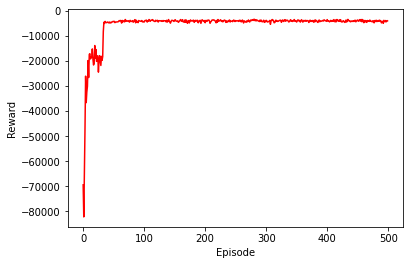

In [5]:
Target_turb = scipy.io.loadmat('Target_turb.mat')
U_target=Target_turb['u2_all']
t_target = np.arange(0, 5.025, 0.025).reshape(1,201)
max_episodes = 500
max_steps = 199
batch_size = 128
wind_tunnel_model = np.array([ [0.8, 0.15,  0.1,  0., 0., 0.,  0.,  0.],
       [0.15, 0.9,  0.15,  0.1, 0., 0.,  0.,  0.],
       [0.1, 0.15,  0.9,  0.15, 0.1, 0.,  0.,  0.],
       [0., 0.1,  0.15,  0.9, 0.15, 0.1,  0.,  0.],
       [0., 0.,  0.1,  0.15, 0.9, 0.15,  0.1,  0.],
       [0., 0.,  0.,  0.1, 0.15, 0.9,  0.15,  0.1],
       [0., 0.,  0.,  0., 0.1, 0.15,  0.9,  0.15],
       [0., 0.,  0.,  0., -0., 0.1,  0.15,  0.8]])

env = wind_tunnel(U_target, wind_tunnel_model)
agent = DDPGagent(env, tau = 1e-3, max_buffer_size = 10000, critic_lr = 1e-3, actor_lr = 1e-4)

rewards = []
avg_rewards = []
episode_rewards = []
t = trange(max_episodes)

for episode in t:
    observation = env.reset()
    episode_reward = 0

    for step in range(max_steps):
        action = agent.get_action(observation)
        action = agent.noise(action, step)
        observation_new, reward, terminated, truncated, _ = env.step(action, step) 
        len_buffer = agent.add_buffer(observation, action, reward, observation_new, terminated)
        
        if len_buffer > batch_size:
            agent.update()      
        
        observation = observation_new
        episode_reward += reward

        if terminated or truncated or step == max_steps-1:
            print("Episode " + str(episode) + ": " , np.round(episode_reward, decimals=2))  
            break

        t.set_postfix(reward = reward,  timesteps = step, totalreward = episode_reward)

    rewards.append(episode_reward)

plt.figure()
plt.plot(rewards, color = 'r')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

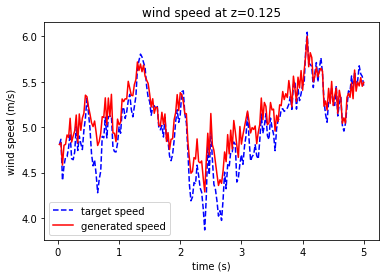

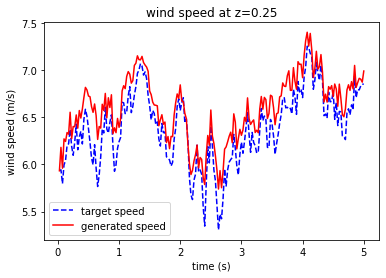

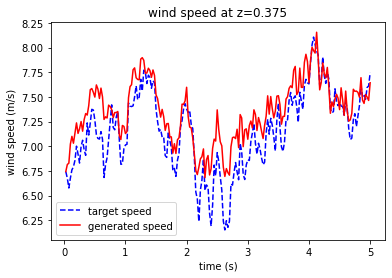

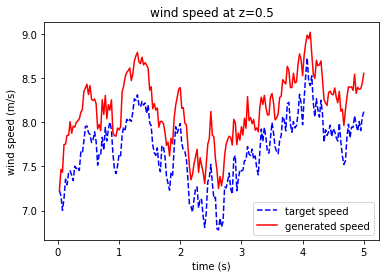

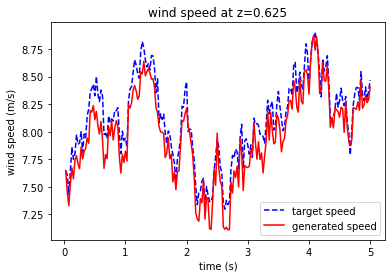

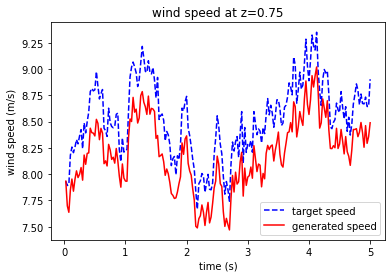

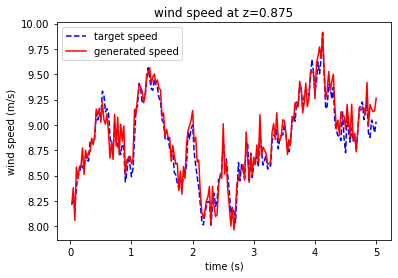

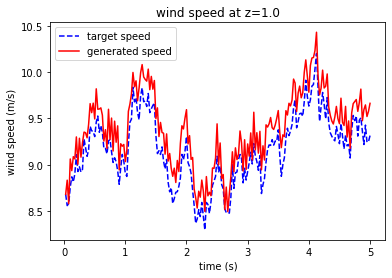

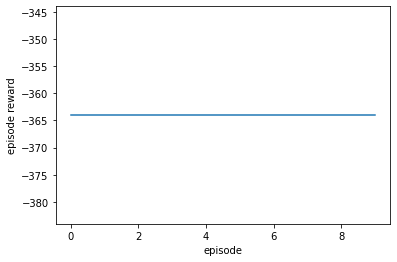

In [6]:
max_test_episode = 10
total_reward_test = []       

for test_episode in range(max_test_episode):
    state_test = env.reset()
    episode_reward_test = 0

    if test_episode == max_test_episode-1:
        state_history_cont=np.zeros((max_steps+1,32))
        state_history_cont[0,:]=state_test

    for step in range(max_steps):        
        action_test = agent.get_action(state_test) 
        next_state_test, reward_test, terminated, truncated, _ = env.step(action_test, step)
        episode_reward_test += reward_test         
        state_test = next_state_test

        if test_episode == max_test_episode-1:
            state_history_cont[step+1,:]=state_test

    total_reward_test.append(episode_reward_test)

for fan_num in range(8):
    plt.figure()
    plt.plot(t_target[0,1:],U_target[fan_num,0:max_steps+1], label='target speed',linestyle='--', color = 'b')
    plt.plot(t_target[0,1:],state_history_cont[:,fan_num], label='generated speed', color = 'r')
    plt.xlabel('time (s)')
    plt.ylabel('wind speed (m/s)')
#     plt.ylim([3,12])
    plt.legend()
    plt.title('wind speed at z='+ str((fan_num + 1) * 0.125))
    plt.show()

plt.figure()
plt.plot(total_reward_test)
plt.xlabel('episode')
plt.ylabel('episode reward')
plt.show()


Text(0, 0.5, 'height')

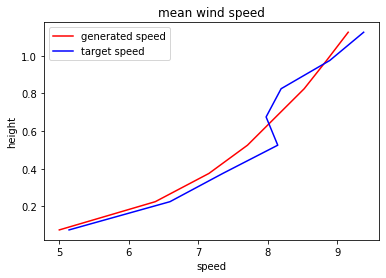

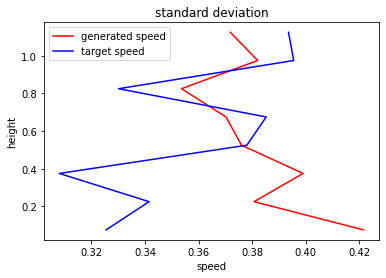

In [7]:
speed_target_means = np.mean(U_target[0:8,0:max_steps+1], axis=1)
speed_generated_means = np.mean(state_history_cont[:,0:8], axis=0)
speed_target_std = np.std(U_target[0:8,0:max_steps+1], axis=1)
speed_generated_std = np.std(state_history_cont[:,0:8], axis=0)
h = np.linspace(0.075, 1.125, 8)

plt.figure()    
plt.plot(speed_target_means,h, label = 'generated speed', color = 'r')
plt.plot(speed_generated_means,h, label = 'target speed', color = 'b')
plt.legend()
plt.title('mean wind speed')
plt.xlabel('speed')
plt.ylabel('height')


plt.figure()    
plt.plot(speed_target_std,h, label = 'generated speed', color = 'r')
plt.plot(speed_generated_std,h, label = 'target speed', color = 'b')
plt.legend()
plt.title('standard deviation')
plt.xlabel('speed')
plt.ylabel('height')

  1%|          | 1/100 [00:11<18:09, 11.00s/it, reward=-81.9, timesteps=15, totalreward=-882]        

Episode 0:  -2842833.34


  2%|▏         | 2/100 [00:23<19:30, 11.94s/it, reward=-117, timesteps=19, totalreward=-1.4e+3]      

Episode 1:  -2707480.72


  3%|▎         | 3/100 [00:35<19:05, 11.81s/it, reward=-64.1, timesteps=24, totalreward=-1.15e+3]    

Episode 2:  -1526303.8


  4%|▍         | 4/100 [00:46<18:14, 11.40s/it, reward=-31.6, timesteps=13, totalreward=-327]        

Episode 3:  -1035338.09


  5%|▌         | 5/100 [00:57<17:48, 11.25s/it, reward=-33.8, timesteps=20, totalreward=-656]     

Episode 4:  -27775.42


  6%|▌         | 6/100 [01:08<17:52, 11.41s/it, reward=-19.4, timesteps=15, totalreward=-307]     

Episode 5:  -18555.74


  7%|▋         | 7/100 [01:21<18:05, 11.67s/it, reward=-17.1, timesteps=15, totalreward=-315]     

Episode 6:  -16046.21


  8%|▊         | 8/100 [01:33<18:07, 11.82s/it, reward=-27.5, timesteps=13, totalreward=-290]     

Episode 7:  -15004.49


  9%|▉         | 9/100 [01:45<18:00, 11.87s/it, reward=-11.6, timesteps=13, totalreward=-209]     

Episode 8:  -15367.61


 10%|█         | 10/100 [01:57<17:58, 11.98s/it, reward=-27, timesteps=13, totalreward=-275]       

Episode 9:  -14329.86


 11%|█         | 11/100 [02:08<17:14, 11.63s/it, reward=-18.8, timesteps=21, totalreward=-369]     

Episode 10:  -14495.61


 12%|█▏        | 12/100 [02:19<16:49, 11.47s/it, reward=-22.3, timesteps=20, totalreward=-413]     

Episode 11:  -13595.92


 13%|█▎        | 13/100 [02:30<16:32, 11.41s/it, reward=-19.4, timesteps=18, totalreward=-443]     

Episode 12:  -13972.34


 14%|█▍        | 14/100 [02:42<16:36, 11.59s/it, reward=-22.1, timesteps=16, totalreward=-329]     

Episode 13:  -13205.57


 15%|█▌        | 15/100 [02:54<16:41, 11.79s/it, reward=-33.2, timesteps=13, totalreward=-318]     

Episode 14:  -12989.25


 16%|█▌        | 16/100 [03:07<16:57, 12.11s/it, reward=-44.7, timesteps=18, totalreward=-418]     

Episode 15:  -13235.3


 17%|█▋        | 17/100 [03:19<16:44, 12.10s/it, reward=-12.4, timesteps=16, totalreward=-344]     

Episode 16:  -13476.26


 18%|█▊        | 18/100 [03:31<16:08, 11.81s/it, reward=-27.4, timesteps=17, totalreward=-308]     

Episode 17:  -12651.63


 19%|█▉        | 19/100 [03:42<15:40, 11.61s/it, reward=-21, timesteps=13, totalreward=-275]       

Episode 18:  -13543.95


 20%|██        | 20/100 [03:53<15:29, 11.62s/it, reward=-25.3, timesteps=14, totalreward=-313]     

Episode 19:  -13378.79


 21%|██        | 21/100 [04:05<15:17, 11.61s/it, reward=-20, timesteps=16, totalreward=-341]       

Episode 20:  -13066.09


 22%|██▏       | 22/100 [04:17<15:18, 11.78s/it, reward=-20.6, timesteps=20, totalreward=-334]     

Episode 21:  -13421.7


 23%|██▎       | 23/100 [04:30<15:27, 12.04s/it, reward=-22.3, timesteps=15, totalreward=-326]     

Episode 22:  -12739.35


 24%|██▍       | 24/100 [04:42<15:14, 12.03s/it, reward=-26.1, timesteps=17, totalreward=-428]     

Episode 23:  -13295.24


 25%|██▌       | 25/100 [04:54<15:04, 12.06s/it, reward=-24.9, timesteps=18, totalreward=-492]     

Episode 24:  -12651.51


 26%|██▌       | 26/100 [05:04<14:19, 11.61s/it, reward=-21.2, timesteps=15, totalreward=-267]     

Episode 25:  -12636.01


 27%|██▋       | 27/100 [05:16<14:15, 11.72s/it, reward=-42.8, timesteps=14, totalreward=-348]     

Episode 26:  -13432.2


 28%|██▊       | 28/100 [05:28<14:09, 11.80s/it, reward=-22.5, timesteps=14, totalreward=-348]     

Episode 27:  -13438.04


 29%|██▉       | 29/100 [05:41<14:05, 11.91s/it, reward=-27.8, timesteps=12, totalreward=-252]     

Episode 28:  -12993.25


 30%|███       | 30/100 [05:52<13:48, 11.84s/it, reward=-15.2, timesteps=17, totalreward=-322]     

Episode 29:  -13417.41


 31%|███       | 31/100 [06:04<13:27, 11.70s/it, reward=-10.4, timesteps=19, totalreward=-285]     

Episode 30:  -12441.37


 32%|███▏      | 32/100 [06:16<13:23, 11.81s/it, reward=-27.8, timesteps=19, totalreward=-360]     

Episode 31:  -14094.55


 33%|███▎      | 33/100 [06:27<13:10, 11.79s/it, reward=-27, timesteps=20, totalreward=-443]       

Episode 32:  -12955.3


 34%|███▍      | 34/100 [06:39<12:49, 11.66s/it, reward=-17.5, timesteps=14, totalreward=-270]     

Episode 33:  -13197.14


 35%|███▌      | 35/100 [06:51<12:46, 11.79s/it, reward=-23.9, timesteps=14, totalreward=-390]     

Episode 34:  -13320.77


 36%|███▌      | 36/100 [07:03<12:43, 11.92s/it, reward=-12.4, timesteps=15, totalreward=-212]     

Episode 35:  -13677.27


 37%|███▋      | 37/100 [07:14<12:21, 11.77s/it, reward=-14.4, timesteps=15, totalreward=-317]     

Episode 36:  -12796.74


 38%|███▊      | 38/100 [07:26<12:03, 11.67s/it, reward=-25.7, timesteps=15, totalreward=-336]     

Episode 37:  -13234.3


 39%|███▉      | 39/100 [07:38<11:57, 11.77s/it, reward=-29.4, timesteps=16, totalreward=-280]     

Episode 38:  -12381.61


 40%|████      | 40/100 [07:50<11:54, 11.91s/it, reward=-16.8, timesteps=18, totalreward=-398]     

Episode 39:  -13874.26


 41%|████      | 41/100 [08:01<11:30, 11.71s/it, reward=-24.7, timesteps=22, totalreward=-558]     

Episode 40:  -12688.93


 42%|████▏     | 42/100 [08:13<11:11, 11.57s/it, reward=-25.2, timesteps=17, totalreward=-401]     

Episode 41:  -13069.01


 43%|████▎     | 43/100 [08:25<11:18, 11.91s/it, reward=-15.8, timesteps=18, totalreward=-398]     

Episode 42:  -12441.98


 44%|████▍     | 44/100 [08:37<11:09, 11.95s/it, reward=-15.7, timesteps=15, totalreward=-296]     

Episode 43:  -13170.56


 45%|████▌     | 45/100 [08:49<10:49, 11.80s/it, reward=-11.5, timesteps=20, totalreward=-405]     

Episode 44:  -12351.37


 46%|████▌     | 46/100 [09:00<10:34, 11.75s/it, reward=-12.1, timesteps=19, totalreward=-476]     

Episode 45:  -12699.67


 47%|████▋     | 47/100 [09:13<10:27, 11.83s/it, reward=-26.2, timesteps=18, totalreward=-471]     

Episode 46:  -11985.0


 48%|████▊     | 48/100 [09:24<10:08, 11.70s/it, reward=-28.8, timesteps=15, totalreward=-427]     

Episode 47:  -13836.83


 49%|████▉     | 49/100 [09:35<09:51, 11.60s/it, reward=-36.5, timesteps=20, totalreward=-421]     

Episode 48:  -13385.69


 50%|█████     | 50/100 [09:47<09:45, 11.71s/it, reward=-28.2, timesteps=15, totalreward=-342]     

Episode 49:  -13512.91


 51%|█████     | 51/100 [09:59<09:38, 11.80s/it, reward=-14, timesteps=16, totalreward=-270]       

Episode 50:  -13671.89


 52%|█████▏    | 52/100 [10:11<09:30, 11.89s/it, reward=-24.4, timesteps=13, totalreward=-335]     

Episode 51:  -13169.01


 53%|█████▎    | 53/100 [10:24<09:31, 12.16s/it, reward=-24, timesteps=16, totalreward=-354]       

Episode 52:  -12808.29


 54%|█████▍    | 54/100 [10:35<09:04, 11.83s/it, reward=-23.6, timesteps=16, totalreward=-298]     

Episode 53:  -12558.38


 55%|█████▌    | 55/100 [10:47<08:54, 11.89s/it, reward=-11.6, timesteps=13, totalreward=-342]     

Episode 54:  -12717.62


 56%|█████▌    | 56/100 [10:59<08:35, 11.72s/it, reward=-23.7, timesteps=13, totalreward=-347]     

Episode 55:  -12326.24


 57%|█████▋    | 57/100 [11:10<08:17, 11.58s/it, reward=-9.68, timesteps=19, totalreward=-321]     

Episode 56:  -13335.84


 58%|█████▊    | 58/100 [11:22<08:11, 11.70s/it, reward=-25.5, timesteps=16, totalreward=-309]     

Episode 57:  -13129.33


 59%|█████▉    | 59/100 [11:34<08:05, 11.85s/it, reward=-16.9, timesteps=14, totalreward=-235]     

Episode 58:  -13422.59


 60%|██████    | 60/100 [11:46<07:59, 12.00s/it, reward=-34.9, timesteps=19, totalreward=-439]     

Episode 59:  -13202.16


 61%|██████    | 61/100 [11:58<07:41, 11.84s/it, reward=-15.4, timesteps=17, totalreward=-370]     

Episode 60:  -13278.38


 62%|██████▏   | 62/100 [12:09<07:27, 11.78s/it, reward=-19.8, timesteps=17, totalreward=-378]     

Episode 61:  -13073.55


 63%|██████▎   | 63/100 [12:22<07:22, 11.95s/it, reward=-16.3, timesteps=9, totalreward=-139]      

Episode 62:  -13366.93


 64%|██████▍   | 64/100 [12:33<07:04, 11.78s/it, reward=-24.9, timesteps=13, totalreward=-251]     

Episode 63:  -13359.91


 65%|██████▌   | 65/100 [12:44<06:46, 11.61s/it, reward=-12, timesteps=13, totalreward=-248]       

Episode 64:  -13939.32


 66%|██████▌   | 66/100 [12:56<06:39, 11.75s/it, reward=-14.1, timesteps=14, totalreward=-182]     

Episode 65:  -12952.55


 67%|██████▋   | 67/100 [13:09<06:31, 11.86s/it, reward=-28.7, timesteps=15, totalreward=-355]     

Episode 66:  -13030.03


 68%|██████▊   | 68/100 [13:20<06:18, 11.83s/it, reward=-32.6, timesteps=17, totalreward=-417]     

Episode 67:  -13119.12


 69%|██████▉   | 69/100 [13:32<06:04, 11.77s/it, reward=-13.6, timesteps=13, totalreward=-207]     

Episode 68:  -13642.61


 70%|███████   | 70/100 [13:44<05:54, 11.82s/it, reward=-14.7, timesteps=13, totalreward=-271]     

Episode 69:  -13228.34


 71%|███████   | 71/100 [13:56<05:46, 11.95s/it, reward=-22, timesteps=18, totalreward=-339]       

Episode 70:  -13040.47


 72%|███████▏  | 72/100 [14:07<05:22, 11.52s/it, reward=-23.2, timesteps=16, totalreward=-375]     

Episode 71:  -13070.39


 73%|███████▎  | 73/100 [14:19<05:15, 11.67s/it, reward=-23, timesteps=16, totalreward=-369]       

Episode 72:  -13158.38


 74%|███████▍  | 74/100 [14:31<05:11, 11.97s/it, reward=-30.9, timesteps=18, totalreward=-388]     

Episode 73:  -12865.88


 75%|███████▌  | 75/100 [14:43<05:00, 12.00s/it, reward=-22.4, timesteps=17, totalreward=-323]     

Episode 74:  -12825.68


 76%|███████▌  | 76/100 [14:55<04:43, 11.82s/it, reward=-33.3, timesteps=20, totalreward=-412]     

Episode 75:  -12788.51


 77%|███████▋  | 77/100 [15:07<04:32, 11.83s/it, reward=-21, timesteps=13, totalreward=-286]       

Episode 76:  -12842.33


 78%|███████▊  | 78/100 [15:19<04:21, 11.91s/it, reward=-8.25, timesteps=13, totalreward=-201]     

Episode 77:  -13195.75


 79%|███████▉  | 79/100 [15:29<04:01, 11.49s/it, reward=-23.5, timesteps=15, totalreward=-407]     

Episode 78:  -13659.93


 80%|████████  | 80/100 [15:41<03:52, 11.62s/it, reward=-18.8, timesteps=13, totalreward=-361]     

Episode 79:  -13439.39


 81%|████████  | 81/100 [15:53<03:44, 11.79s/it, reward=-20.9, timesteps=15, totalreward=-264]     

Episode 80:  -12867.18


 82%|████████▏ | 82/100 [16:06<03:35, 11.96s/it, reward=-26, timesteps=14, totalreward=-253]       

Episode 81:  -12544.38


 83%|████████▎ | 83/100 [16:17<03:19, 11.72s/it, reward=-24.5, timesteps=15, totalreward=-282]     

Episode 82:  -12841.76


 84%|████████▍ | 84/100 [16:29<03:11, 11.95s/it, reward=-48, timesteps=17, totalreward=-575]       

Episode 83:  -12724.68


 85%|████████▌ | 85/100 [16:41<02:59, 11.95s/it, reward=-29, timesteps=17, totalreward=-438]       

Episode 84:  -13698.47


 86%|████████▌ | 86/100 [16:53<02:45, 11.80s/it, reward=-17.4, timesteps=22, totalreward=-396]     

Episode 85:  -13395.06


 87%|████████▋ | 87/100 [17:04<02:31, 11.66s/it, reward=-15.5, timesteps=13, totalreward=-286]     

Episode 86:  -12922.26


 88%|████████▊ | 88/100 [17:16<02:21, 11.82s/it, reward=-23.6, timesteps=11, totalreward=-228]     

Episode 87:  -12565.63


 89%|████████▉ | 89/100 [17:29<02:11, 11.92s/it, reward=-39.5, timesteps=14, totalreward=-430]     

Episode 88:  -13197.7


 90%|█████████ | 90/100 [17:40<01:58, 11.83s/it, reward=-25, timesteps=15, totalreward=-372]       

Episode 89:  -13681.13


 91%|█████████ | 91/100 [17:52<01:45, 11.73s/it, reward=-25.3, timesteps=15, totalreward=-314]     

Episode 90:  -13048.91


 92%|█████████▏| 92/100 [18:04<01:34, 11.81s/it, reward=-15.3, timesteps=17, totalreward=-374]     

Episode 91:  -12519.74


 93%|█████████▎| 93/100 [18:16<01:23, 11.94s/it, reward=-12.2, timesteps=17, totalreward=-304]     

Episode 92:  -13327.58


 94%|█████████▍| 94/100 [18:27<01:10, 11.70s/it, reward=-16.8, timesteps=16, totalreward=-244]     

Episode 93:  -13267.83


 95%|█████████▌| 95/100 [18:39<00:59, 11.80s/it, reward=-19.2, timesteps=16, totalreward=-368]     

Episode 94:  -13709.31


 96%|█████████▌| 96/100 [18:51<00:47, 11.93s/it, reward=-16.6, timesteps=14, totalreward=-193]     

Episode 95:  -13329.61


 97%|█████████▋| 97/100 [19:03<00:35, 11.98s/it, reward=-25.3, timesteps=14, totalreward=-269]     

Episode 96:  -12795.15


 98%|█████████▊| 98/100 [19:16<00:24, 12.03s/it, reward=-11.1, timesteps=15, totalreward=-217]     

Episode 97:  -12562.76


 99%|█████████▉| 99/100 [19:27<00:11, 11.72s/it, reward=-19, timesteps=13, totalreward=-252]       

Episode 98:  -12825.87


100%|██████████| 100/100 [19:38<00:00, 11.79s/it, reward=-7.73, timesteps=997, totalreward=-1.35e+4]


Episode 99:  -13536.15


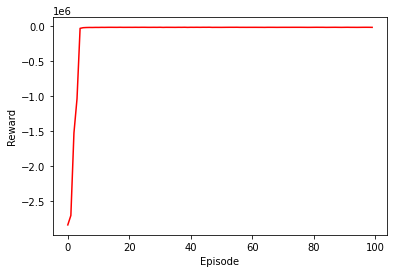

In [11]:
Target_turb = scipy.io.loadmat('Target_turb.mat')
U_target=Target_turb['u2_all']
t_target = np.arange(0, 25.025, 0.025).reshape(1,1001)
max_episodes = 100
max_steps = 999
batch_size = 128
wind_tunnel_model = np.array([ [0.8, 0.15,  0.1,  0., 0., 0.,  0.,  0.],
       [0.15, 0.9,  0.15,  0.1, 0., 0.,  0.,  0.],
       [0.1, 0.15,  0.9,  0.15, 0.1, 0.,  0.,  0.],
       [0., 0.1,  0.15,  0.9, 0.15, 0.1,  0.,  0.],
       [0., 0.,  0.1,  0.15, 0.9, 0.15,  0.1,  0.],
       [0., 0.,  0.,  0.1, 0.15, 0.9,  0.15,  0.1],
       [0., 0.,  0.,  0., 0.1, 0.15,  0.9,  0.15],
       [0., 0.,  0.,  0., -0., 0.1,  0.15,  0.8]])

env = wind_tunnel(U_target, wind_tunnel_model)
agent = DDPGagent(env, tau = 1e-3, max_buffer_size = 10000, critic_lr = 1e-3, actor_lr = 1e-4)

rewards = []
avg_rewards = []
episode_rewards = []
t = trange(max_episodes)

for episode in t:
    observation = env.reset()
    episode_reward = 0

    for step in range(max_steps):
        action = agent.get_action(observation)
        action = agent.noise(action, step)
        observation_new, reward, terminated, truncated, _ = env.step(action, step) 
        len_buffer = agent.add_buffer(observation, action, reward, observation_new, terminated)
        
        if len_buffer > batch_size:
            agent.update()      
        
        observation = observation_new
        episode_reward += reward

        if terminated or truncated or step == max_steps-1:
            print("Episode " + str(episode) + ": " , np.round(episode_reward, decimals=2))  
            break

        t.set_postfix(reward = reward,  timesteps = step, totalreward = episode_reward)

    rewards.append(episode_reward)

plt.figure()
plt.plot(rewards, color = 'r')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

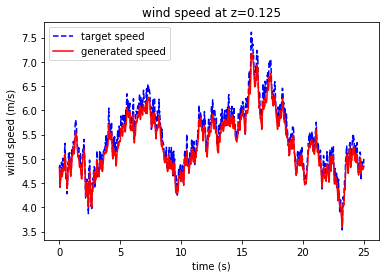

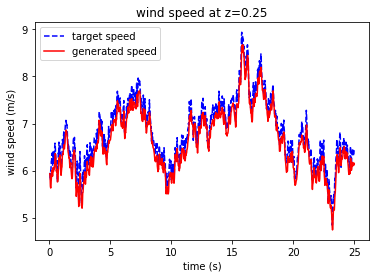

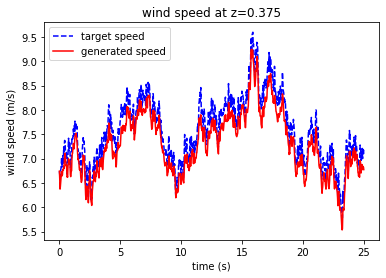

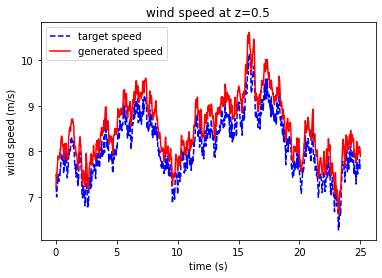

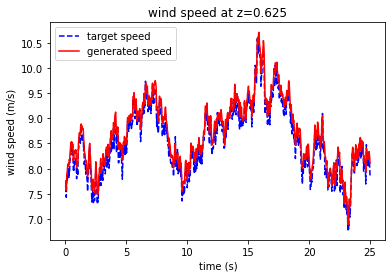

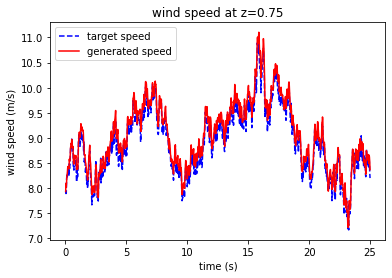

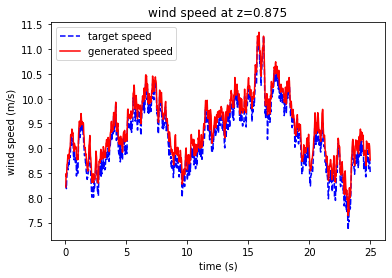

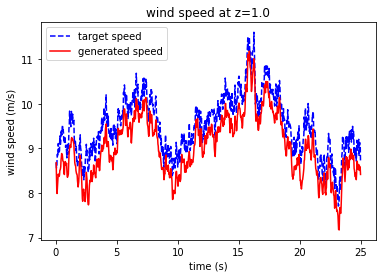

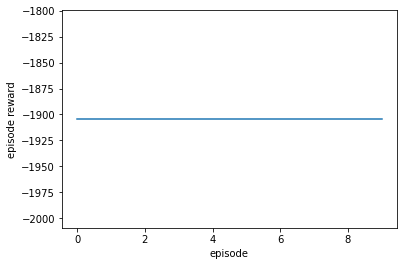

In [12]:
max_test_episode = 10
total_reward_test = []       

for test_episode in range(max_test_episode):
    state_test = env.reset()
    episode_reward_test = 0

    if test_episode == max_test_episode-1:
        state_history_cont=np.zeros((max_steps+1,32))
        state_history_cont[0,:]=state_test

    for step in range(max_steps):        
        action_test = agent.get_action(state_test) 
        next_state_test, reward_test, terminated, truncated, _ = env.step(action_test, step)
        episode_reward_test += reward_test         
        state_test = next_state_test

        if test_episode == max_test_episode-1:
            state_history_cont[step+1,:]=state_test

    total_reward_test.append(episode_reward_test)

for fan_num in range(8):
    plt.figure()
    plt.plot(t_target[0,1:],U_target[fan_num,0:max_steps+1], label='target speed',linestyle='--', color = 'b')
    plt.plot(t_target[0,1:],state_history_cont[:,fan_num], label='generated speed', color = 'r')
    plt.xlabel('time (s)')
    plt.ylabel('wind speed (m/s)')
#     plt.ylim([3,12])
    plt.legend()
    plt.title('wind speed at z='+ str((fan_num + 1) * 0.125))
    plt.show()

plt.figure()
plt.plot(total_reward_test)
plt.xlabel('episode')
plt.ylabel('episode reward')
plt.show()


Text(0, 0.5, 'height')

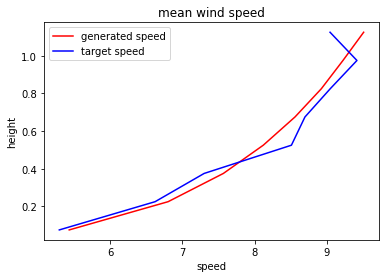

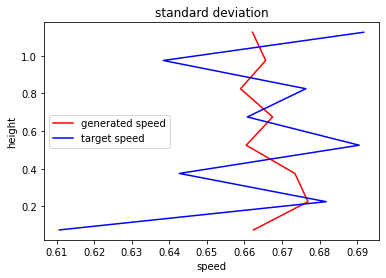

In [13]:
speed_target_means = np.mean(U_target[0:8,0:max_steps+1], axis=1)
speed_generated_means = np.mean(state_history_cont[:,0:8], axis=0)
speed_target_std = np.std(U_target[0:8,0:max_steps+1], axis=1)
speed_generated_std = np.std(state_history_cont[:,0:8], axis=0)
h = np.linspace(0.075, 1.125, 8)

plt.figure()    
plt.plot(speed_target_means,h, label = 'generated speed', color = 'r')
plt.plot(speed_generated_means,h, label = 'target speed', color = 'b')
plt.legend()
plt.title('mean wind speed')
plt.xlabel('speed')
plt.ylabel('height')


plt.figure()    
plt.plot(speed_target_std,h, label = 'generated speed', color = 'r')
plt.plot(speed_generated_std,h, label = 'target speed', color = 'b')
plt.legend()
plt.title('standard deviation')
plt.xlabel('speed')
plt.ylabel('height')